<p align="center">
  <img src="https://i.ytimg.com/vi/Wm8ftqDZUVk/maxresdefault.jpg" alt="FIUBA" width="33%"/>
  </p>
  
# **Trabajo Práctico 1: Reservas de Hotel**
### **Checkpoint**: 1
### **Grupo**: 11 - Los Pandas
### **Cuatrimestre**: 2ºC 2023
### **Corrector**: Mateo Suster
### **Integrantes**:
### 103456 - Labollita, Francisco
### 102312 - Mundani Vegega, Ezequiel
###  97263 - Otegui, Matías Iñaki

# Introducción

En el siguiente trabajo práctico se propone abordar un problema real de ciencia de datos, investigar cada una de las etapas del proceso y resolverlo aplicando los contenidos desarrollados en clase.  
También, a partir de un conjunto de datos de reservas de hotel dado por la cátedra, aplicar técnicas de análisis exploratorio, preprocesamiento de datos y entrenar un modelo de clasificación con el objetivo de predecir si una reserva será o no cancelada.

# CP1: Análisis Exploratorio y Preprocesamiento de Datos

## a) Exploración Inicial

### Carga inicial de dependencias y datos

En primer lugar, se cargan las dependencias a utilizar

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calendar
import warnings

# Aclaración:
# Hay un warning que puede llegar a aparecer que es debido a una actualización interna de Seaborn que será deprecada, para solucionarlo hay que modificar el código de python
# directamente (lo cual no es una buena práctica).
# La función en concreto se va a seguir utilizando, por lo que no afecta a nuestro código en sí, si no al comportamiento interno de dicha función.
# Se propone ignorar dicho warninig, ya que se solucionará en la próxima versión de Python
# En el siguiente enlace se puede encontrar más información:
# https://github.com/ultralytics/ultralytics/issues/4729
# https://github.com/mwaskom/seaborn/issues/3462
#
# se puede ignorar descomentando las siguientes líneas

warnings.filterwarnings('ignore', 'is_categorical_dtype is deprecated')
warnings.filterwarnings("ignore", "use_inf_as_na")

# o bien otra solución (más elegante), es obtener dicha actualización corriendo esta línea:
# pip install -U ultralytics

y se cargan los datos de reserva de hoteles en el siguiente dataframe:

In [2]:
hotels_train_url = 'hotels_train.csv'
hotels_df = pd.read_csv(hotels_train_url)
hotels_df_backup = hotels_df.copy()

Se modifica el tamaño por defecto de los gráficos:

In [3]:
plt.rcParams['figure.figsize'] = [4, 4]

A continuación, se presentan las primeras 5 filas listadas con todas las respectivas columnas para tener una idea general de como se ven los datos para comenzar a analizarlos:

In [4]:
hotels_df.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,No Deposit,9.0,NaN,0,Transient,115.5,0,1,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,No Deposit,NaN,NaN,0,Transient,42.0,1,0,b1428f80-c56c-4ae4-91a9-6962edae08b1,0
2,City Hotel,25,2016,October,42,13,0,1,2,2.0,...,No Deposit,9.0,NaN,0,Transient,229.0,0,2,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0
3,City Hotel,26,2016,December,51,12,2,5,2,0.0,...,Non Refund,154.0,NaN,0,Transient,75.0,0,0,314f56dc-2e4d-4298-9bdd-27bb008bffff,1
4,City Hotel,104,2017,March,12,19,2,5,2,0.0,...,No Deposit,20.0,NaN,0,Transient-Party,75.0,0,1,28c75445-c603-413a-babf-ad377018b592,0


In [5]:
hotels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61913 entries, 0 to 61912
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           61913 non-null  object 
 1   lead_time                       61913 non-null  int64  
 2   arrival_date_year               61913 non-null  int64  
 3   arrival_date_month              61913 non-null  object 
 4   arrival_date_week_number        61913 non-null  int64  
 5   arrival_date_day_of_month       61913 non-null  int64  
 6   stays_in_weekend_nights         61913 non-null  int64  
 7   stays_in_week_nights            61913 non-null  int64  
 8   adults                          61913 non-null  int64  
 9   children                        61909 non-null  float64
 10  babies                          61913 non-null  int64  
 11  meal                            61913 non-null  object 
 12  country                         

Hay un total de 31 columnas y 61.914 filas. De todos estos parámetros, se tendrán en cuenta aquellos que sirvan, en nuestro criterio, sean de utilidad para entrenar el modelo predictivo.  
Se propone analizar cada parámetro individualmente y, al finalizar, presentar un pequeño resumen con las conclusiones de este análisis inicial.

### Datos Faltantes

Para averiguar la cantidad de datos faltantes para cada variable se hace una sumatoria de todos los valores NaN que contenga cada columna. Para el caso particular de market_segment y distribution_channel se tomarán los valores ingresados como "undefined" como datos faltantes. Esta información servirá luego para al analizar cada variable por separado saber cuáles tienen datos faltantes.


In [6]:
datosFaltantes_df = pd.DataFrame(columns = ["Variable","Valores Faltantes", "Porcentaje"])

for i in hotels_df:
    nValoresFaltantes = hotels_df[i].isna().sum()
    if nValoresFaltantes > 0:
        datosFaltantes_df.loc[len(datosFaltantes_df.index)] = (i, nValoresFaltantes, (nValoresFaltantes*100/len(hotels_df.index)))

nValoresFaltantes = hotels_df['market_segment'].value_counts()['Undefined']
datosFaltantes_df.loc[len(datosFaltantes_df.index)] = ["market_segment", nValoresFaltantes, (nValoresFaltantes*100/len(hotels_df.index))]

nValoresFaltantes = hotels_df['distribution_channel'].value_counts()['Undefined']
datosFaltantes_df.loc[len(datosFaltantes_df.index)] = ["distribution_channel", nValoresFaltantes, (nValoresFaltantes*100/len(hotels_df.index))]

datosFaltantes_df.sort_values(by=["Porcentaje"], ascending = False, inplace = True)

datosFaltantes_df.style.hide(axis="index").format(precision = 3, decimal = ',', thousands = '.')

Variable,Valores Faltantes,Porcentaje
company,58.761,"94,909"
agent,7.890,"12,744"
country,221,"0,357"
children,4,"0,006"
distribution_channel,4,"0,006"
market_segment,2,"0,003"


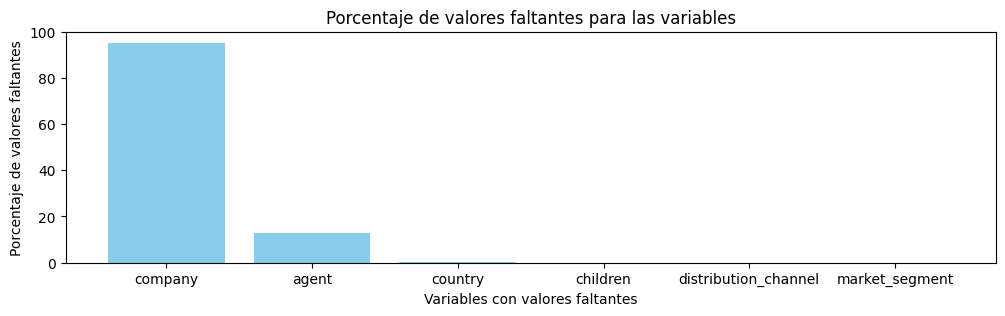

In [7]:
plt.figure(figsize=(12, 3))
plt.bar(datosFaltantes_df["Variable"], datosFaltantes_df["Porcentaje"], color='skyblue')
plt.title('Porcentaje de valores faltantes para las variables')
plt.xlabel('Variables con valores faltantes')
plt.ylabel('Porcentaje de valores faltantes')
plt.ylim(0, 100)
plt.show()

### Parámetros

#### hotel

El parámetro es un _string_ que indica el nombre del hotel. Es una **Variable Independiente Cualitativa de Texto Nominal** ya que es una etiqueta (nombre del hotel) con valores no relacionados entre sí. Es simplemente una forma de identificar el establecimiento.  

Se puede observar que la mayoría de los registros provienen del _City Hotel_, siendo un poco menos del 70% del total.

Se presentan, a modo de visualización, dos **gráficos** con la cantidad de veces que aparece cada nombre y si su reserva fue cancelada:

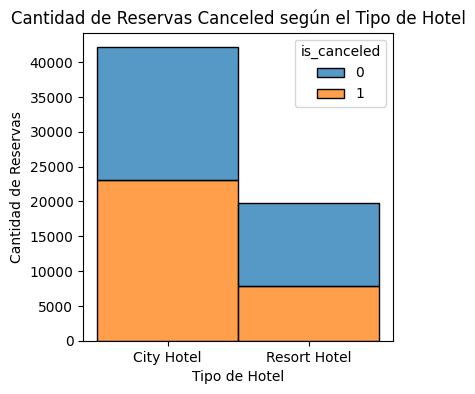

In [8]:
columns = ['hotel', 'is_canceled']
data = hotels_df[columns]

sns.histplot(data=data, x='hotel', hue='is_canceled', multiple='stack', legend=True)
plt.xlabel('Tipo de Hotel')
plt.ylabel('Cantidad de Reservas')
plt.title('Cantidad de Reservas Canceled según el Tipo de Hotel')
plt.show()

Luego se muestra el porcentaje de cancelación para cada hotel:

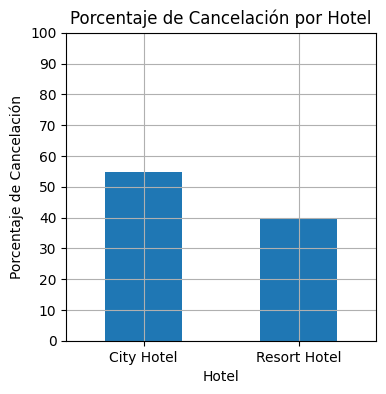

In [9]:
canceled_df = hotels_df[hotels_df['is_canceled'] == 1]
hotel_cancelation_percentage = canceled_df.groupby('hotel')['is_canceled'].count() / hotels_df.groupby('hotel')['is_canceled'].count() * 100

ax = hotel_cancelation_percentage.plot(kind='bar')
plt.title('Porcentaje de Cancelación por Hotel')
plt.xlabel('Hotel')
plt.ylabel('Porcentaje de Cancelación')
plt.yticks(range(0, 101, 10))
plt.xticks(rotation=0)
plt.grid()
ax.set_ylim(0, 100)
plt.show()

De esta manera, se puede observar que el _City Hotel_ tiene un porcentaje de cancelación del 55% y el _Resort Hotel_ del 40%. Por lo tanto, el parámetro _hotel_ es **relevante** y está relacionado con el **target**.

#### lead_time

El parámetro indica el número de días que transcurrieron entre la fecha de entrada de la reserva en el sistema y la fecha de ingreso del cliente al hotel.

El parámetro es un _integer_ de tipo **Variable Independiente Cuantitativa Discreta**, ya que es una medida discreta del tiempo y no se toman otros intervalos de tiempo. Se propone calcular la Media, la Mediana, la Varianza, la Desviación Estándar, la Moda, la Covarianza con respecto al target y la Correlación de Pearson con respecto al target.

In [10]:
parameter_column = hotels_df['lead_time'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a target): ", covarianza)
print("Correlación de Pearson (con respecto a target): ", pearson)

Media:  112.24818697204141
Mediana:  78.0
Varianza:  12258.267122558873
Desviación Estandar:  110.71705885977497
Moda:  0
Covarianza (con respecto a target):  16.265487254459007
Correlación de Pearson (con respecto a target):  0.2938160884261427


La **Media** indica el valor promedio obtenido, que teniendo en cuenta lo desarrollado anteriormente, puede aproximarse a 112 días.

La **Mediana** indica el valor que se encuentra en el centro de un conjunto de datos al estar ordenados en orden ascendente o descendente. En este caso, el valor obtenido es de 78 días, pero para decidir cual utilizar en caso de una corrección (si la Media o la Mediana), lo mejor es visualizar los datos en un gráfico y observar su distribución.

La **Varianza** indica cuán dispersos o agrupados están los valores en relación con la media (promedio) de los datos.

La **Desviación Estandar** se utiliza para cuantificar la dispersión o la variabilidad de un conjunto de datos. En este caso, el valor es muy grande, más de lo esperable, lo que llevaría a pensar que es posible que haya valores atípicos o que necesiten corrección.

La **Moda** representa el valor, o los valores, más frecuentes en el conjunto de datos. En este caso, el 0 podría indicar que la reserva se hizo el mismo día de llegada (osea no hubo reserva), o bien que no se tienen datos concretos para esa fila. Se debe realizar una investigación más profunda.

La **Covarianza** es positiva, significa que cuando una variable aumenta, la otra tiende a aumentar también. Si fuera negativa, sería el caso contrario y su fuese cero (o cercana a cero) no tendrian relación entre sí. Dado que la covarianza puede ser afectada por valores atípicos en los datos, esto puede hacer que sea difícil de interpretar. Por lo que se propone, analizar también la Correlación de Pearson.  

En el caso de la **Correlación de Pearson**, dado que es positiva, esto podría indicar que a medida que el tiempo entre la reserva y la fecha de llegada aumenta, la probabilidad de cancelación tiende a aumentar, lo que podría sugerir una relación positiva. Si fuese negativa esto indicaría una relación inversa y si fuese 0 no se observaría una relación lineal fuerte entre estas dos variables.
Dado que su relación es más cercana a 0 que 1 pero positiva, se puede concluir que su relación no es completamente fuerte, pero se espera una mayor cancelación de la reserva a medida que pasa el tiempo.

Se propone continuar investigando mediante un gráfico de barras en el tiempo:

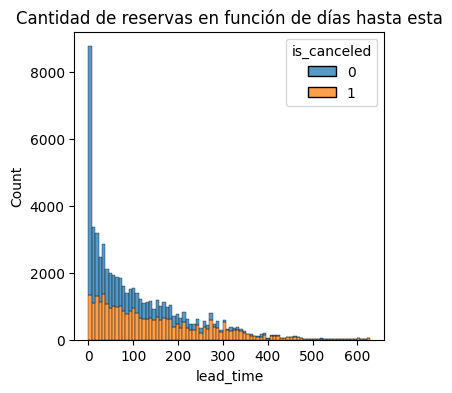

In [11]:
plt.figure()
sns.histplot(hotels_df[['lead_time', 'is_canceled']], x='lead_time', hue='is_canceled', multiple='stack', legend=True)
plt.title('Cantidad de reservas en función de días hasta esta')
plt.show()

Del gráfico anterior se ve que la mayoría de las reservas se hacen con poca anticipación y que a medida que aumenta el tiempo hasta la fecha de la reserva es más probable que sea cancelada.

Para verificar el porcentaje de cancelaciones con respecto al tiempo, se propone dividir el *lead_time* en intervalos de 30 días (aproximadamente 1 mes).

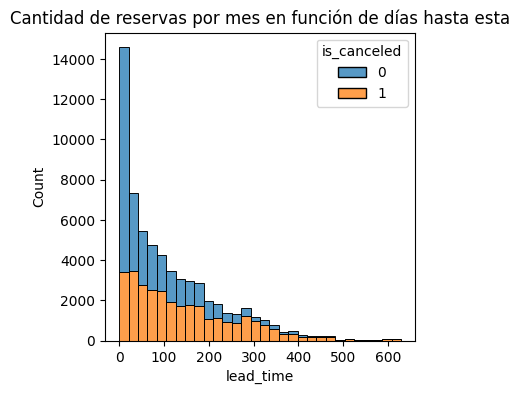

In [12]:
plt.figure()
sns.histplot(hotels_df[['lead_time', 'is_canceled']], x='lead_time', hue='is_canceled', multiple='stack', legend=True, bins=30)
plt.title('Cantidad de reservas por mes en función de días hasta esta')
plt.show()

Este gráfico es más claro que el anterior incluso, ya que toma períodos de tiempo. Para poder comparar si realmente es relevante la variable, se propone ahora tomar porcentajes por intervalos.

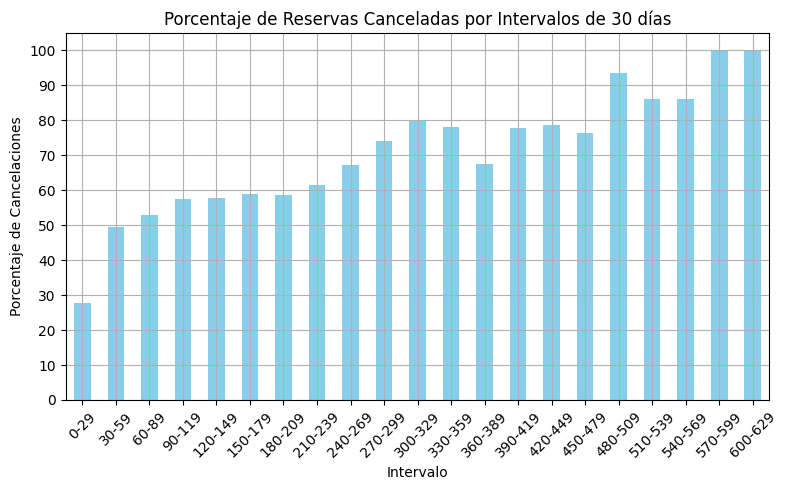

In [13]:
hotels_cancelations = hotels_df[hotels_df['is_canceled'] == 1]
hotels_cancelations_per_lead_time = hotels_cancelations['lead_time'].value_counts().sort_index()

hotels_lead_time_cancel_intervals = list(range(0, max(hotels_cancelations["lead_time"].tolist()) + 31, 30))
hotels_lead_time_cancel_labels = [f'{i}-{i+29}' for i in hotels_lead_time_cancel_intervals[:-1]]
hotels_cancelations_per_lead_time_intervalos = pd.cut(hotels_cancelations_per_lead_time.index, bins=hotels_lead_time_cancel_intervals, labels=hotels_lead_time_cancel_labels, include_lowest=True)
hotel_cancelations_per_interval = hotels_cancelations_per_lead_time.groupby(hotels_cancelations_per_lead_time_intervalos, observed=False).sum()

hotels_df['lead_time_intervals'] = pd.cut(hotels_df['lead_time'], bins=hotels_lead_time_cancel_intervals, labels=hotels_lead_time_cancel_labels, include_lowest=True)
reservas_por_intervalo = hotels_df['lead_time_intervals'].value_counts().sort_index()
cancelaciones_por_intervalo = hotels_df[hotels_df['is_canceled'] == 1]['lead_time_intervals'].value_counts().sort_index()
porcentajes_cancelaciones = (cancelaciones_por_intervalo / reservas_por_intervalo) * 100

plt.figure(figsize=(8, 5))
porcentajes_cancelaciones.plot(kind='bar', color='skyblue')
plt.title('Porcentaje de Reservas Canceladas por Intervalos de 30 días')
plt.xlabel('Intervalo')
plt.ylabel('Porcentaje de Cancelaciones')
plt.yticks(range(0, 101, 10))
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# regreso hotels_df a su estado original
hotels_df = hotels_df_backup.copy()

Como puede observarse, con una reserva de menos de 30 días las probabilidades de que dicha reserva sea cancelada son mucho menores a las de mayor tiempo. A partir de los 2 meses las probabilidades superan el 50% y a medida que pasa el tiempo es aún más probable. Incluso a partir de los 570 días ya es una 100% de probabilidad de que dicha reserva sea cancelada.

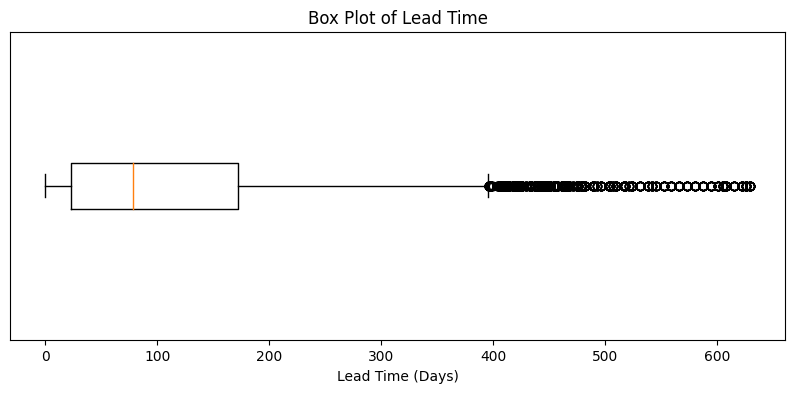

In [14]:
plt.figure(figsize=(10, 4))
plt.boxplot(hotels_df['lead_time'], vert=False)
plt.xlabel('Lead Time (Days)')
plt.yticks([])
plt.title('Box Plot of Lead Time')
plt.show()

A partir del boxplot se ve que al entrenar el modelo, habría que utilizar la información hasta el día 400. Las reservas con más de 400 días las consideramos outliers y tiene sentido dado a que no es normal que alguien reserve una habitación con más de 400 días de anticipación.

Esto significa que *lead_time* es un parámetro **relevante** para el entrenamiento del modelo y está relacionado con **target**.  
Por otro lado, también es un indicador que cuanto más tiempo pase, más probable será que la reserva sea cancelada.

#### arrival_date_year

El parámetro describe el año de arribo. En sí no es un parámetro relevante para predecir futuras cancelaciones de reservas. Es un dato que puede resultar útil para estudiar porque hubo un aumento o disminución de reservas, por ejemplo por alguna crisis mundial económica; pero más allá de eso, no servirá para entrenar el modelo para reservas futuras. Aunque podría utilizarse, para predecir las cancelaciones en esos años en concreto, pero la idea sería poder utilizar el modelo en el futuro en los próximos años, por lo que es **irrelevante** y su relación con el **target** ayuda a explicar hechos pasados, pero no necesariamente futuros en este caso puntual.

Es una **Variable Independiente Cuantitativa Discreta**, ya que es un intervalo de tiempo discretizado. Se propone calcular la Media, la Mediana, la Varianza, la Desviación Estándar, la Moda, la Covarianza con respecto al target y la Correlación de Pearson con respecto al target.

In [15]:
parameter_column = hotels_df['arrival_date_year'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a target): ", covarianza)
print("Correlación de Pearson (con respecto a target): ", pearson)

Media:  2016.1547494064253
Mediana:  2016.0
Varianza:  0.5018065016562059
Desviación Estandar:  0.7083830190343399
Moda:  2016
Covarianza (con respecto a target):  0.007056767925435907
Correlación de Pearson (con respecto a target):  0.019923274956089875


La mayoría de las reservas ocurrieron en el 2016, los años poseen una desviación estandar chica. Además, la covarianza y la correlación de Pearson revelan un valor muy cercano a 0, por lo que no guardan una relación fuerte con el **target**.

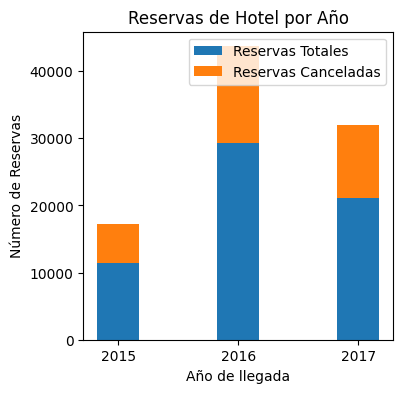

In [16]:
total_reservas_per_year = hotels_df.groupby('arrival_date_year')['is_canceled'].count()
reservas_canceladas_per_year = hotels_df[hotels_df['is_canceled'] == 1].groupby('arrival_date_year')['is_canceled'].count()
years = total_reservas_per_year.index
fig, ax = plt.subplots()
ancho_barra = 0.35
barra_total = ax.bar(years, total_reservas_per_year,\
                        width = ancho_barra,\
                        label='Reservas Totales')
barra_cancelada = ax.bar(years, reservas_canceladas_per_year,\
                         width = ancho_barra,\
                         label = 'Reservas Canceladas',\
                         bottom = total_reservas_per_year)


ax.set_xlabel('Año de llegada')
ax.set_ylabel('Número de Reservas')
ax.set_title('Reservas de Hotel por Año')
ax.set_xticks(years)
ax.legend()
plt.show()

Si bien se puede observar que la mayor cantidad de reservas provienen del año 2016, el porcentaje de reservas/cancelaciones parecería ser el mismo. A continuación, se puede verificar esto:

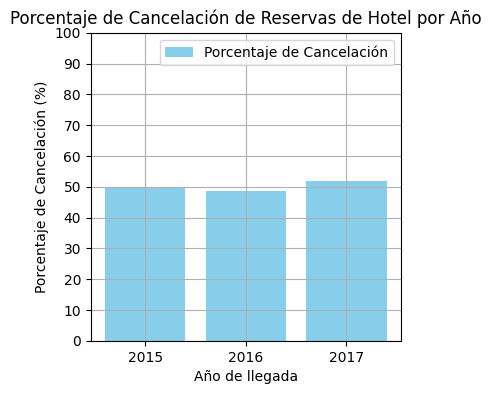

In [17]:
cancelations_perc_per_year = (hotels_df.groupby('arrival_date_year')['is_canceled'].mean() * 100).round(2)

years = cancelations_perc_per_year.index
fig, ax = plt.subplots()
ax.bar(years, cancelations_perc_per_year, color='skyblue', label='Porcentaje de Cancelación')
ax.set_ylim(0, 100)

ax.set_xlabel('Año de llegada')
ax.set_ylabel('Porcentaje de Cancelación (%)')
ax.set_title('Porcentaje de Cancelación de Reservas de Hotel por Año')
ax.set_xticks(years)
plt.yticks(range(0, 101, 10))
ax.grid()
ax.legend()

plt.show()

Como puede observarse, el porcentaje de cancelación de reservas se mantiene aproximadamente constante, lo que se condice con la suposicción de que iba a ser **Irrelevante**

#### arrival_date_month

De forma similar al anterior, este parámetro podría decirse que continúa con la misma línea de pensamiento, pero es necesario investigar para estar seguros, ya que podría suceder que haya más cancelaciones según la época del año, o que afecte si es temporada alta o baja.

Es una **Variable Independiente Cualitativa Texto Nominal** debido a que es una etiqueta no relacionada, que solamente indica el mes.

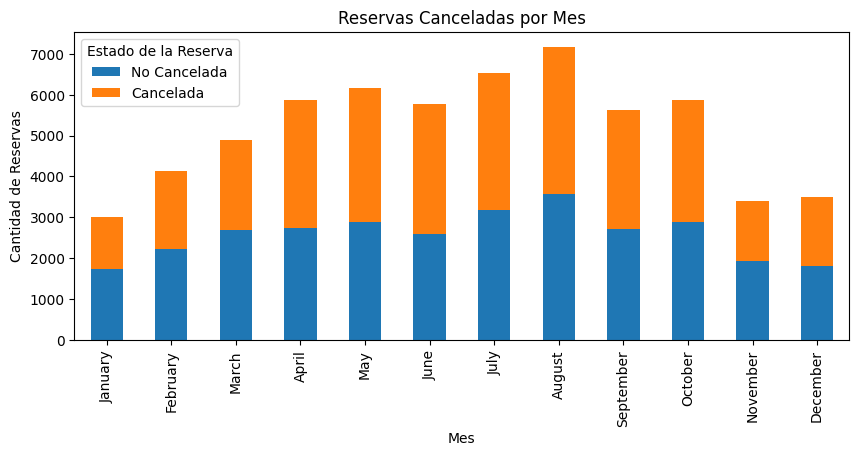

In [18]:
monthly_cancelations = hotels_df.groupby(['arrival_date_month', 'is_canceled']).size().unstack()
ordered_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_cancelations = monthly_cancelations.reindex(ordered_months)

ax = monthly_cancelations.plot(kind='bar', stacked=True, figsize=(10, 4))
plt.title('Reservas Canceladas por Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Reservas')
plt.legend(['No Cancelada', 'Cancelada'], title='Estado de la Reserva')

plt.show()

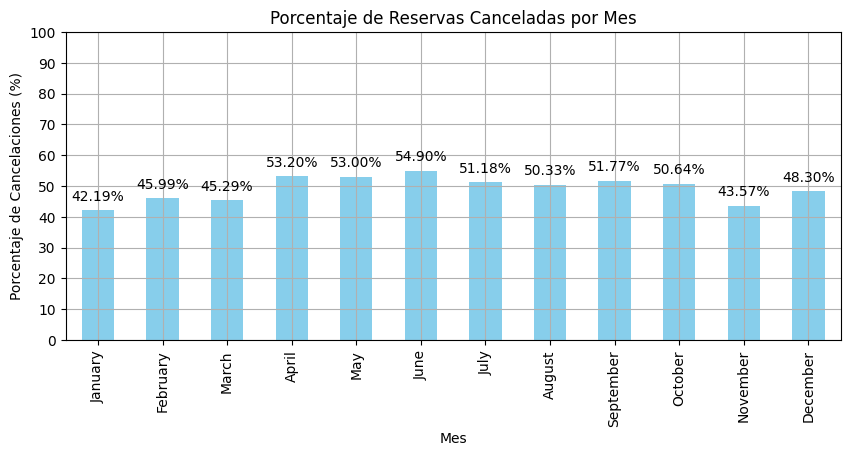

In [19]:
monthly_totals = hotels_df.groupby('arrival_date_month').size()
monthly_cancelations = hotels_df[hotels_df['is_canceled'] == 1].groupby('arrival_date_month').size()
monthly_cancelation_percentage = (monthly_cancelations / monthly_totals) * 100
ordered_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_cancelation_percentage = monthly_cancelation_percentage.reindex(ordered_months)

max_percentage = monthly_cancelation_percentage.max()

plt.figure()
ax = monthly_cancelation_percentage.plot(kind='bar', figsize=(10, 4), color='skyblue')
plt.title('Porcentaje de Reservas Canceladas por Mes')
plt.xlabel('Mes')
plt.ylabel('Porcentaje de Cancelaciones (%)')
plt.yticks(range(0, 101, 10))
plt.grid()
plt.ylim(0, 100)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.show()

Como puede observarse en el gráfico superior, hay mayor porcentaje de cancelaciones en junio que en enero, por lo que es un parámetro **relevante** a la hora de entrenar el modelo y se debe destacar que mantiene una relación con respecto al **target**.

#### arrival_date_week_number

Este parámetro se refiere al número de semana en el año en que está la reserva. Puede llegar a ser importante para determinar temporadas altas o bajas, aunque la información que da debería ser la misma que la de arrival_date_month solo que con algo más específica. Es una **Variable Independiente Cuantitativa Discreta**, puesto que es una discretización del tiempo.

Se muestran las medidas de resumen:

In [20]:
parameter_column = hotels_df['arrival_date_week_number'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a target): ", covarianza)
print("Correlación de Pearson (con respecto a target): ", pearson)

Media:  27.21808020932599
Mediana:  28.0
Varianza:  182.95000211609326
Desviación Estandar:  13.525901157264652
Moda:  33
Covarianza (con respecto a target):  0.05652184137557416
Correlación de Pearson (con respecto a target):  0.008357437316708986


Observando la Covarianza y la Correlación de Pearson, con sus valores cercanos a 0, ya comienza a dar una idea de que no es un parámetro que parezca tener dependencia lineal con el target.

Finalmente, se vuelcan los resultados en un gráfico de barras con porcentajes de cancelaciones por intervalo de 4 semanas.

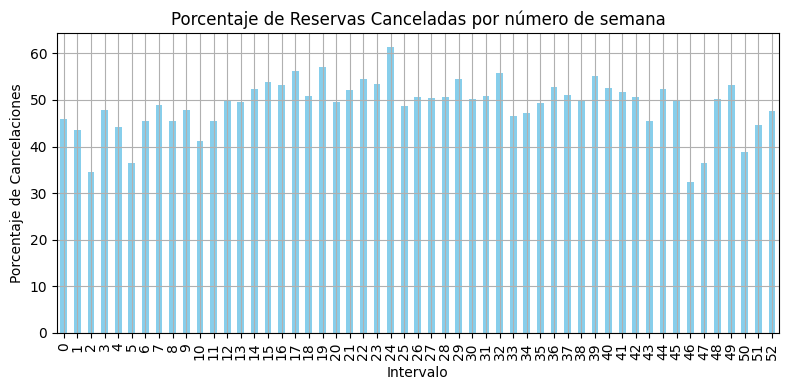

In [21]:
hotels_adwn_cancel_intervals = list(range(0, max(hotels_cancelations["arrival_date_week_number"].tolist()) + 5, 1))
hotels_adwn_cancel_labels = [f'{i}' for i in hotels_adwn_cancel_intervals[:-1]]

hotels_df['adwn_intervals'] = pd.cut(hotels_df['arrival_date_week_number'], bins=hotels_adwn_cancel_intervals, labels=hotels_adwn_cancel_labels, include_lowest=True)
reservas_por_intervalo = hotels_df['adwn_intervals'].value_counts().sort_index()
cancelaciones_por_intervalo = hotels_df[hotels_df['is_canceled'] == 1]['adwn_intervals'].value_counts().sort_index()
porcentajes_cancelaciones = (cancelaciones_por_intervalo / reservas_por_intervalo) * 100

plt.figure(figsize=(8, 4))
porcentajes_cancelaciones.plot(kind='bar', color='skyblue')
plt.title('Porcentaje de Reservas Canceladas por número de semana')
plt.xlabel('Intervalo')
plt.ylabel('Porcentaje de Cancelaciones')
plt.yticks(range(0, 61, 10))
plt.xlim(-0.5, 52.5)
plt.grid()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# regreso hotels_df a su estado original
hotels_df = hotels_df_backup.copy()

Como puede observarse, no hay una diferencia particularmente apreciable, aunque hay fluctuaciones. Hay menos cancelaciones durante las primeras semanas del año, parecido a lo observado en arrival_date_month. Al momento de entrenar el modelo pareciera que el mes o el número de semana dan información bastante similar, guardando una relación con el **target**, por lo tanto se considera **relevante**.

#### arrival_date_day_of_month

En un principio, podría pensarse que continúa la misma línea de pensamiento que el parámetro anterior, pero lo mejor es investigar más ya que podría suceder que cambie según si es el comienzo, la mitad o el final del mes. Es una **Variable Independiente Cuantitativa Discreta**, ya que es una variable de tiempo discretizada.

Se propone calcular las medidas de resumen:

In [22]:
parameter_column = hotels_df['arrival_date_day_of_month'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a target): ", covarianza)
print("Correlación de Pearson (con respecto a target): ", pearson)

Media:  15.785812349587324
Mediana:  16.0
Varianza:  77.35936972151046
Desviación Estandar:  8.79541754105571
Moda:  17
Covarianza (con respecto a target):  -0.03241407010888681
Correlación de Pearson (con respecto a target):  -0.007370554150145503


A partir de los datos proporcionados, no parece que haya una relación clara, incluso la Correlación de Pearson dio negativa y cercana a 0, lo que significaría que no hay una relación estrecha con la variable **target**.

Se propone mostrar esto en un gráfico de tipo Histograma:

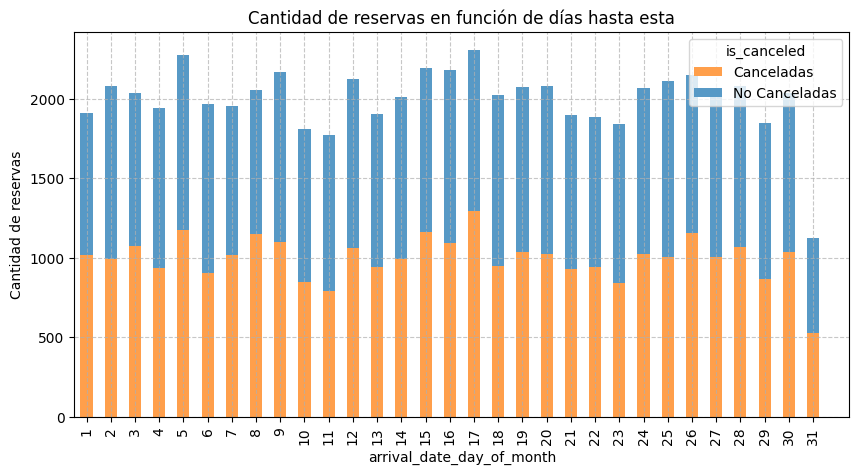

In [23]:
reservas = hotels_df.groupby(['arrival_date_day_of_month', 'is_canceled']).size().unstack()
reservas = reservas[[1, 0]]

reservas.plot(kind='bar', stacked=True,  color=['#FF9F4B', '#5799C6'], figsize=(10, 5))
plt.xlim(-0.5, 31.5)
plt.title('Cantidad de reservas en función de días hasta esta')
plt.ylabel('Cantidad de reservas')
plt.legend(loc='upper right', title='is_canceled', labels=['Canceladas', 'No Canceladas'])
plt.grid(linestyle='--', alpha=0.7)
plt.show()

Se propone mostrar ahora con porcentajes:

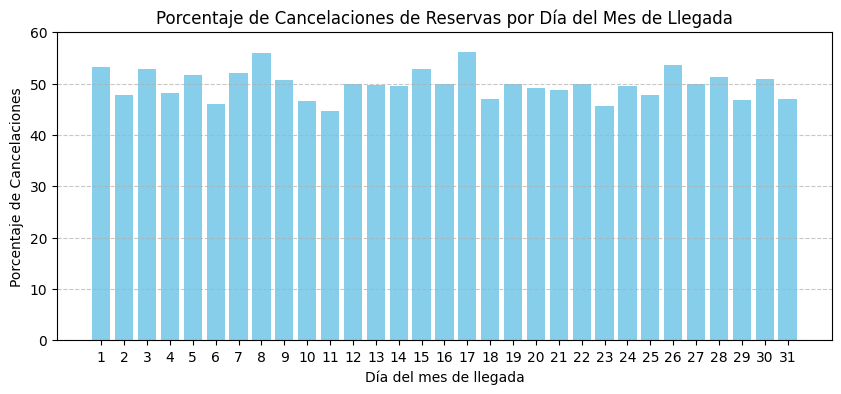

In [24]:
total_reservations_by_day = hotels_df['arrival_date_day_of_month'].value_counts().sort_index()
cancelled_reservations = hotels_df[hotels_df['is_canceled'] == 1]
cancelations_by_day = cancelled_reservations['arrival_date_day_of_month'].value_counts().sort_index()

percentages = (cancelations_by_day / total_reservations_by_day) * 100

plt.figure(figsize=(10, 4))
plt.bar(percentages.index, percentages.values, color='skyblue')
plt.xlabel('Día del mes de llegada')
plt.ylabel('Porcentaje de Cancelaciones')
plt.title('Porcentaje de Cancelaciones de Reservas por Día del Mes de Llegada')
plt.yticks(range(0, 61, 10))
plt.xticks(range(1, 32))
plt.ylim(0, 60)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Ahora, es aún más claro que el porcentaje no cambia de manera significativa en el tiempo. Por lo que se puede concluir que este parámetro es **irrelevante** para el entrenamiento del modelo y no guarda una relación estrecha con el **target**

#### stays_in_weekend_nights

Este parámetro es una **Variable Independiente Cuantitativa Discreta**, ya que es una discretización del tiempo. Dice cuántas noches de fin de semana se reservaron. Se propone, tal y como antes, las medidas de resumen:

In [25]:
parameter_column = hotels_df['stays_in_weekend_nights'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a target): ", covarianza)
print("Correlación de Pearson (con respecto a target): ", pearson)

Media:  0.9241354804322194
Mediana:  1.0
Varianza:  0.986233333089822
Desviación Estandar:  0.9930928119213339
Moda:  0
Covarianza (con respecto a target):  0.0006351611956761096
Correlación de Pearson (con respecto a target):  0.0012791372744576411


No parece que haya un relación clara con respecto al **target**, pero se propone graficar el total de reservas canceladas según la cantidad de noches de fin de semana y el porcentaje de cancelaciones para cada valor posible:

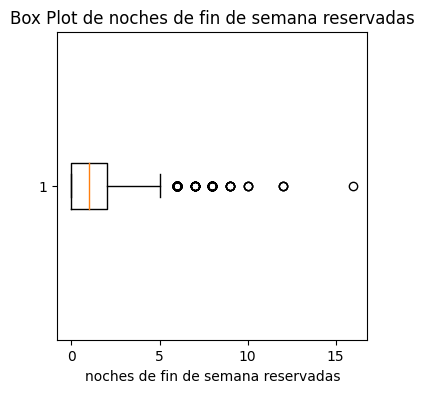

In [26]:
plt.figure()
plt.boxplot(hotels_df['stays_in_weekend_nights'], vert=False)
plt.xlabel('noches de fin de semana reservadas')
plt.title('Box Plot de noches de fin de semana reservadas')
plt.show()

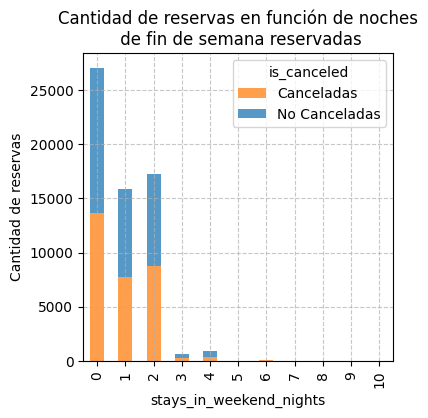

In [27]:
reservas = hotels_df.groupby(['stays_in_weekend_nights', 'is_canceled']).size().unstack()
reservas = reservas[[1, 0]]

reservas.plot(kind='bar', stacked=True,  color=['#FF9F4B', '#5799C6'])
plt.xlim(-0.5, 10.5)
plt.title('Cantidad de reservas en función de noches\n de fin de semana reservadas')
plt.ylabel('Cantidad de reservas')
plt.legend(title='is_canceled', labels=['Canceladas', 'No Canceladas'])
plt.grid(linestyle='--', alpha=0.7)
plt.show()

Como se puede observar, la mayoría de la gente no reserva más de 2 noches de fin de semana. Para el caso de los porcentajes:

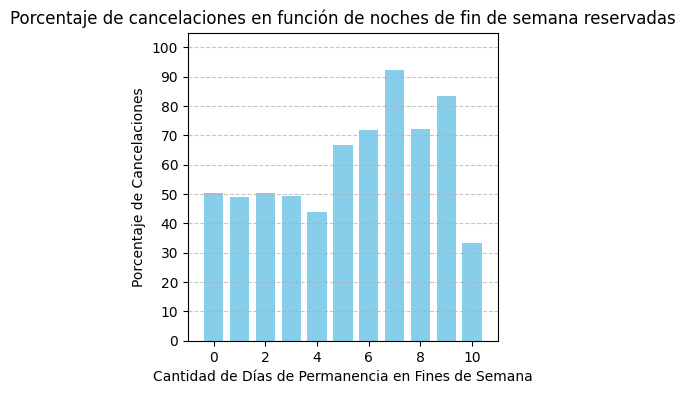

In [28]:
cancelled_reservations = hotels_df[hotels_df['is_canceled'] == 1]
cancelations_by_weekend_nights = cancelled_reservations['stays_in_weekend_nights'].value_counts().sort_index()

total_reservations_by_weekend_nights = hotels_df['stays_in_weekend_nights'].value_counts().sort_index()
percentages = (cancelations_by_weekend_nights / total_reservations_by_weekend_nights) * 100


plt.figure()
plt.bar(percentages.index, percentages.values, color='skyblue', width=0.75)
plt.xlabel('Cantidad de Días de Permanencia en Fines de Semana')
plt.ylabel('Porcentaje de Cancelaciones')
plt.title('Porcentaje de cancelaciones en función de noches de fin de semana reservadas')
plt.xticks()
plt.xlim(-1,11)
plt.yticks(range(0, 101, 10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Analizando el boxplot se ve que no tiene sentido tomar las reservas con más de 5 noches de fin de semana reservadas. 

Analizando lo que pasa durante los primeros 4 días, no se ve una gran variación por lo que el **target** no tiene una relación tan fuerte con esta variable, y se puede considerar **irrelevante** para el entrenamiento del modelo.


#### stays_in_week_nights

Este parámetro es una **Variable Independiente Cuantitativa Discreta**, ya que es una discretización del tiempo. Dice cuántas noches de días de semana se reservaron. En principio, podría pensarse que continúa con la misma lógica del parámetro anterior, por esto se propone investigar un poco más. Tal y como se hizo antes, se presentan las medidas de resumen:

In [29]:
parameter_column = hotels_df['stays_in_week_nights'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a target): ", covarianza)
print("Correlación de Pearson (con respecto a target): ", pearson)

Media:  2.5100544312179993
Mediana:  2.0
Varianza:  3.5528885874786686
Desviación Estandar:  1.884910763797233
Moda:  2
Covarianza (con respecto a target):  0.026802652857020933
Correlación de Pearson (con respecto a target):  0.028438718504006387


En principio, no parecería tener una relación tan fuerte con el **target**.

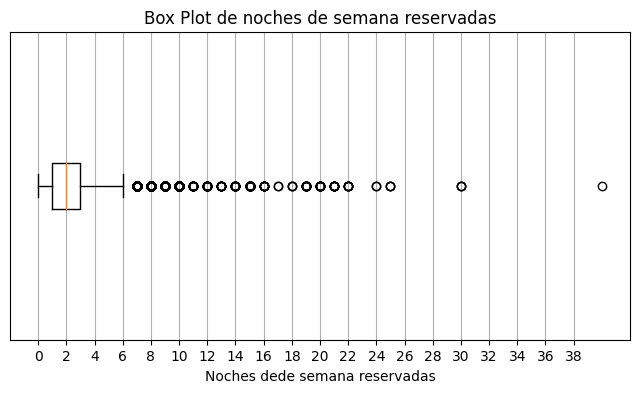

In [30]:
plt.figure(figsize=(8,4))
plt.boxplot(hotels_df['stays_in_week_nights'], vert=False)
plt.xlabel('Noches dede semana reservadas')
plt.xticks(range(0, 40, 2))
plt.grid(axis='x')
plt.yticks([])
plt.title('Box Plot de noches de semana reservadas')
plt.show()

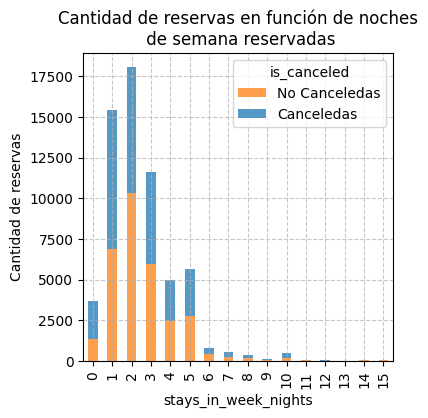

In [31]:
reservas = hotels_df.groupby(['stays_in_week_nights', 'is_canceled']).size().unstack()
reservas = reservas[[1, 0]]

reservas.plot(kind='bar', stacked=True,  color=['#FF9F4B', '#5799C6'])
plt.xlim(-0.5, 15.5)
plt.title('Cantidad de reservas en función de noches\n de semana reservadas')
plt.ylabel('Cantidad de reservas')
plt.legend(title='is_canceled', labels=['No Canceledas', 'Canceledas'])
plt.grid(linestyle='--', alpha=0.7)
plt.show()

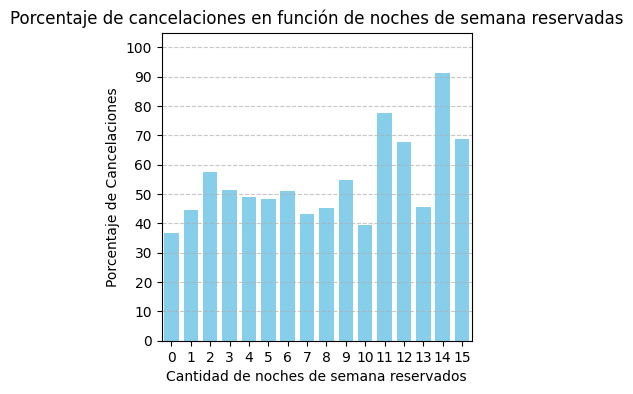

In [32]:
cancelled_reservations = hotels_df[hotels_df['is_canceled'] == 1]
cancelations_by_week_nights = cancelled_reservations['stays_in_week_nights'].value_counts().sort_index()

total_reservations_by_week_nights = hotels_df['stays_in_week_nights'].value_counts().sort_index()
percentages = (cancelations_by_week_nights / total_reservations_by_week_nights) * 100


plt.figure()
plt.bar(percentages.index, percentages.values, color='skyblue', width=0.75)
plt.xlabel('Cantidad de noches de semana reservados')
plt.ylabel('Porcentaje de Cancelaciones')
plt.title('Porcentaje de cancelaciones en función de noches de semana reservadas')
plt.xticks()
plt.xlim(-0.5, 15.5)
plt.xticks(range(0,16))
plt.yticks(range(0, 101, 10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Como puede observarse, la mayor cantidad de datos importan hasta el día 6, luego son realmente muy pocos los datos que se tienen en comparación, pero a partir de ese día ya el cambio es mayor. Dado que no se tienen una cantidad de datos comparables a partir de dicha cantidad de días, es **irrelevante** considerar esta variable, aunque vale la pena aclarar que sí tiene una relación con el **target**, lo que sucede es que resulta lo mejor despreciarla ya que no se tienen tantas reservas a partir del día 6 y además el coeficiente de Pearson da un valor muy bajo (menor a 0,05).

#### adults

El número de adultos podría llegar a ser una variable relevante, teniendo en cuenta que a mayor cantidad de adultos, resulta más dificil planificar un viaje y esto podría llevar a que se cancele la reserva.

 Este parámetro es una **Variable Independiente Cuantitativa Discreta**, por lo que se propone calcular las medidas de resumen:

In [33]:
parameter_column = hotels_df['adults'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a target): ", covarianza)
print("Correlación de Pearson (con respecto a target): ", pearson)

Media:  1.862791336229871
Mediana:  2.0
Varianza:  0.34699356195423825
Desviación Estandar:  0.589061594363644
Moda:  2
Covarianza (con respecto a target):  0.017724726478090883
Correlación de Pearson (con respecto a target):  0.060178570747318826


En general el promedio es de 2 personas adultas, por lo que la mayor cantidad de reservas probablemente sean para parejas. Tampoco parece haber una relación lineal tan fuerte con el **target**.

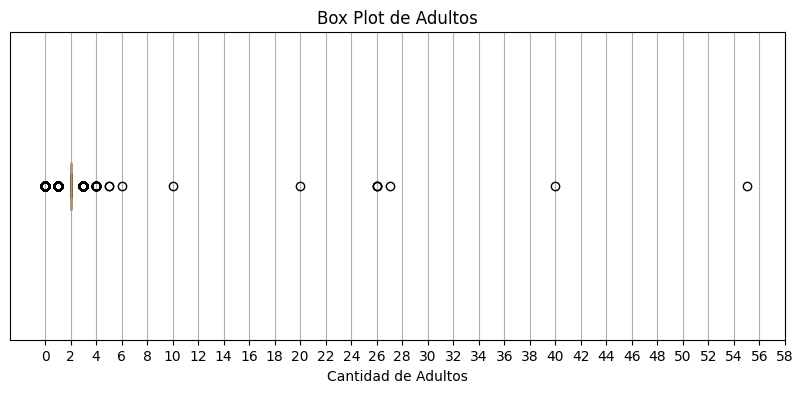

In [34]:
plt.figure(figsize=(10, 4))
plt.boxplot(hotels_df['adults'], vert=False)
plt.xlabel('Cantidad de Adultos')
plt.xticks(range(0, 60, 2))
plt.grid(axis='x')
plt.yticks([])

plt.title('Box Plot de Adultos')
plt.show()

Analizando el boxplot se ve que la gran mayoría de valores estará en 2, y que por su alto volumen hacen que todos los otros valores sean outliers.

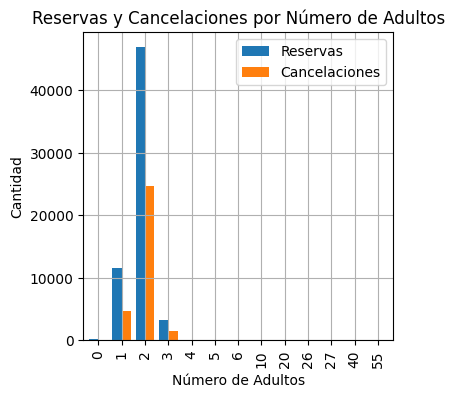

In [35]:
reservations_by_adults = hotels_df['adults'].value_counts().sort_index()
cancelled_reservations = hotels_df[hotels_df['is_canceled'] == 1]
cancelations_by_adults = cancelled_reservations['adults'].value_counts().sort_index()

data = {
    'Reservas': reservations_by_adults.values,
    'Cancelaciones': cancelations_by_adults.values
    }

df = pd.DataFrame(data, index = reservations_by_adults.index)

ax = df.plot(kind='bar', width=0.8)
plt.grid()
plt.xlabel('Número de Adultos')
plt.ylabel('Cantidad')
plt.title('Reservas y Cancelaciones por Número de Adultos')
plt.legend(loc='upper right')
plt.show()

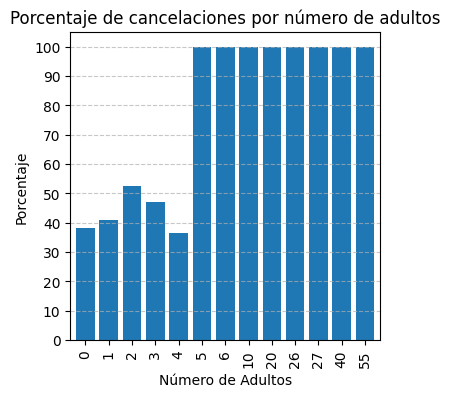

In [36]:
reservations_by_adults = hotels_df['adults'].value_counts().sort_index()
cancelled_reservations = hotels_df[hotels_df['is_canceled'] == 1]
cancelations_by_adults = cancelled_reservations['adults'].value_counts().sort_index()
percentages = (cancelations_by_adults / reservations_by_adults) * 100

df = pd.DataFrame(percentages, index = reservations_by_adults.index)

ax = df.plot(kind='bar', stacked =True, width=0.8)
ax.get_legend().remove()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel('Número de Adultos')
plt.ylabel('Porcentaje')
plt.title('Porcentaje de cancelaciones por número de adultos')
plt.yticks(range(0, 101, 10))
plt.show()


Como se puede observar, para más de 3 adultos parece despreciable la estadística por haber pocos datos. Estos serán considerados atípicos y sus filas eliminadas.

Al observar detenidamente, se puede apreciar que hay una diferencia de un 10% en las cancelaciones al aumentar el número de adultos de 1 a 2, y un valor intermedio al ser 3, pero sigue siendo mayor que 1, aunque no por mucho.

Se concluye que es **relevante** para el entrenamiento del modelo y que guarda una relación con el **target**.

#### children

En cuanto a análisis, este parámetro resulta similar al de _adults_. En este caso es una **Variable Independiente Cuantitativa Discreta**.

In [37]:
hotels_df['children'].info()


<class 'pandas.core.series.Series'>
RangeIndex: 61913 entries, 0 to 61912
Series name: children
Non-Null Count  Dtype  
--------------  -----  
61909 non-null  float64
dtypes: float64(1)
memory usage: 483.8 KB


Se ve que hay 4 valores no definidos (NaN, None) se los reemplaza por ceros para poder hacer las medidas de resumen.

In [38]:
# Dado que hay muchos NaN, se propone reemplazarlos con 0 para obtener las medidas de resumen, ya que si no los resultados arrojan NaN
hotels_df['children'].fillna(0, inplace=True)

parameter_column = hotels_df['children'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a target): ", covarianza)
print("Correlación de Pearson (con respecto a target): ", pearson)

Media:  0.10488911860190914
Mediana:  0.0
Varianza:  0.1622736753799558
Desviación Estandar:  0.4028320684602404
Moda:  0.0
Covarianza (con respecto a target):  0.0012538083301836497
Correlación de Pearson (con respecto a target):  0.006224868049897016


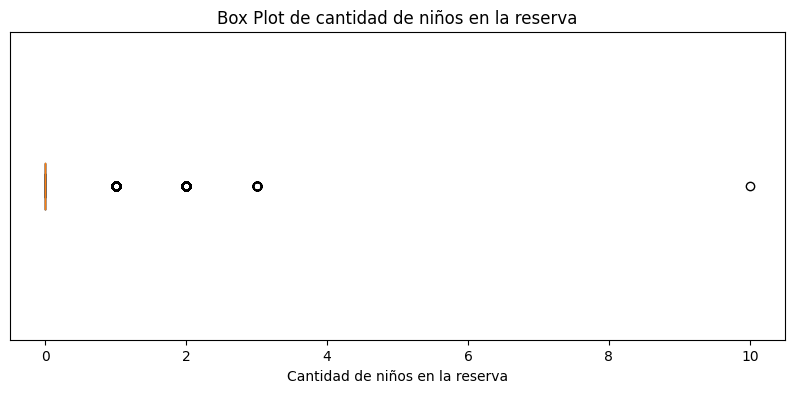

In [39]:
plt.figure(figsize=(10, 4))
plt.boxplot(hotels_df['children'], vert=False)
plt.xlabel('Cantidad de niños en la reserva')
plt.title('Box Plot de cantidad de niños en la reserva')
plt.yticks([])
plt.show()

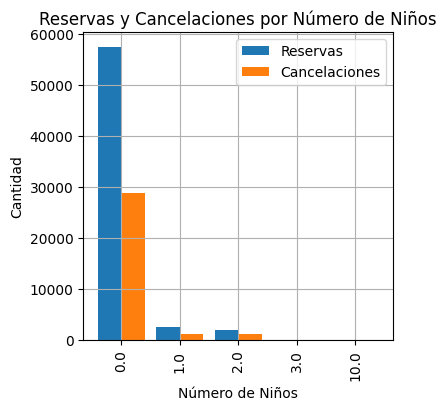

In [40]:
reservations = hotels_df['children'].value_counts().sort_index()
cancelations = hotels_df[hotels_df['is_canceled'] == 1]
cancelations = cancelations['children'].value_counts().sort_index()

data = {
    'Reservas': reservations.values,
    'Cancelaciones': cancelations.values
    }

df = pd.DataFrame(data, index = reservations.index)

ax = df.plot(kind='bar', width=0.8)
plt.grid()
plt.xlabel('Número de Niños')
plt.ylabel('Cantidad')
plt.title('Reservas y Cancelaciones por Número de Niños')
plt.legend(loc='upper right')
plt.show()

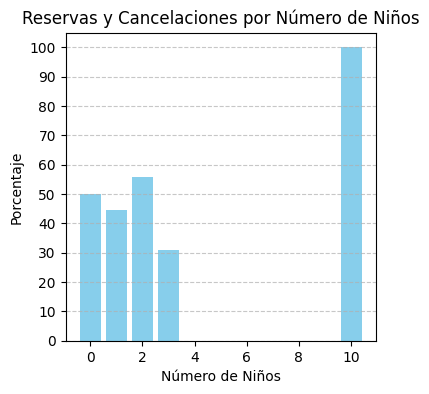

In [41]:
reservations = hotels_df[hotels_df['is_canceled'] == 0]
reservations = hotels_df['children'].value_counts().sort_index()
cancelations = hotels_df[hotels_df['is_canceled'] == 1]
cancelations = cancelled_reservations['children'].value_counts().sort_index()

percentages = (cancelations / reservations) * 100

plt.figure()
plt.bar(percentages.index, percentages.values, color='skyblue', width=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel('Número de Niños')
plt.ylabel('Porcentaje')
plt.yticks(range(0, 101, 10))
plt.title('Reservas y Cancelaciones por Número de Niños')
plt.show()

Por lo general, los adultos viajan sin hijos. Vale aclarar que se reemplazaron los valores NaN con 0, ya que si no arrojaban resultados NaN. No parece haber una relación muy fuerte con respecto a target.

Como se puede observar, no hay una diferencia clara entre cancelar una reserva con hijos o sin hijos, por lo que no afecta al comportamiento realmente el hecho de que tengan o no tengan hijos. Esto significa que no está relacionado con el **target** y es **irrelevante** para el entrenamiento del modelo, lo cual se condice con la Correlación de Pearson muy baja obtenida. No tiene sentido considerar qué hacer con las filas que no tienen este dato porque es un atributo irrelevante.

#### babies

Este parámetro resulta similar al de _children_, pero es una variable dependiente, ya que los bebés no deberían poder viajar solos nunca, si no acompañados de sus padres. En este caso es una **Variable Dependiente Cuantitativa Discreta**.

Se propone calcular las medidas de resumen:

In [42]:
parameter_column = hotels_df['babies'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a target): ", covarianza)
print("Correlación de Pearson (con respecto a target): ", pearson)

Media:  0.007155201653933746
Mediana:  0.0
Varianza:  0.008493050662499106
Desviación Estandar:  0.09215774879248682
Moda:  0
Covarianza (con respecto a target):  -0.0014761127790147972
Correlación de Pearson (con respecto a target):  -0.0320339665770838


Este caso es aún más evidente que el anterior, no guardan ninguna relación con la variable **target**, se propone realizar el mismo procedimiento de comparación que antes:

Como se puede observar, no hay una diferencia clara entre cancelar una reserva con bebes o sin bebes, por lo que no afecta al comportamiento realmente el hecho de que tengan o no tengan bebes. Esto significa que no está relacionado con el **target** y es **irrelevante** para el entrenamiento del modelo, lo cual se condice con la Correlación de Pearson.

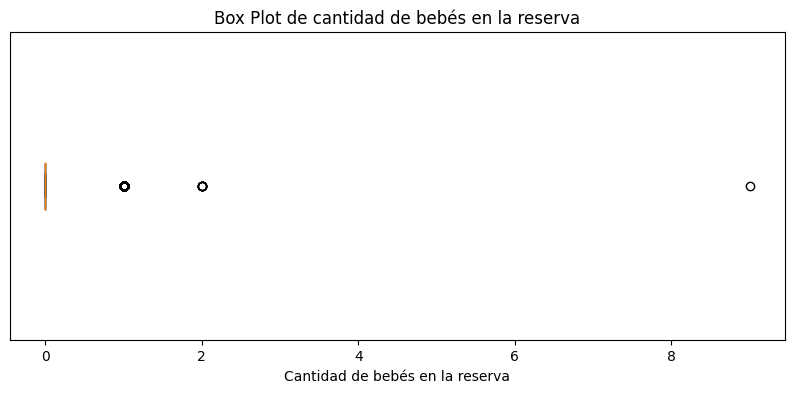

In [43]:
plt.figure(figsize=(10, 4))
plt.boxplot(hotels_df['babies'], vert=False)
plt.xlabel('Cantidad de bebés en la reserva')
plt.title('Box Plot de cantidad de bebés en la reserva')
plt.yticks([])
plt.show()

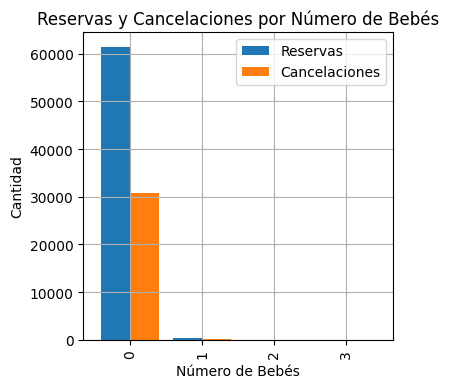

In [44]:
reservations = hotels_df['babies'].value_counts().sort_index()
cancelations = hotels_df['babies']
cancelations = cancelations[hotels_df['is_canceled'] == 1].value_counts().sort_index()
cancelations.loc[9] = 1

data = {
    'Reservas': reservations.values,
    'Cancelaciones': cancelations.values
    }

df = pd.DataFrame(data)

ax = df.plot(kind='bar', width=0.8)
plt.grid()
plt.xlabel('Número de Bebés')
plt.ylabel('Cantidad')
plt.title('Reservas y Cancelaciones por Número de Bebés')
plt.legend(loc='upper right')
plt.show()

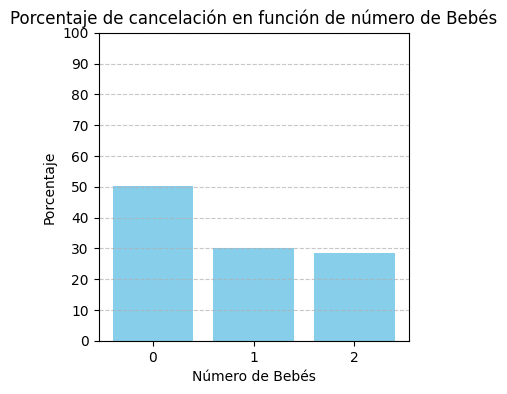

In [45]:
reservations = hotels_df[hotels_df['is_canceled'] == 0]
reservations = hotels_df['babies'].value_counts().sort_index()
cancelations = hotels_df[hotels_df['is_canceled'] == 1]
cancelations = cancelled_reservations['babies'].value_counts().sort_index()

percentages = (cancelations / reservations) * 100

plt.figure()
plt.bar(percentages.index, percentages.values, color='skyblue', width=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel('Número de Bebés')
plt.ylabel('Porcentaje')
plt.yticks(range(0, 101, 10))
plt.xticks(range(0, 3, 1))
plt.title('Porcentaje de cancelación en función de número de Bebés')
plt.show()

En base al boxplot y a la cantidad de reservas con o sin bebés, se puede ver que hay muy pocas reservas con estos por lo cual este dato podrá ser utilizado en muy pocos casos. Aun así. Se puede ver que si tiene bebés la probabilidad de cancelar es de un 30% aproximadamente. Siendo una variable **relevante**.

#### meal

El parámetro indica la comida reservada. Es una **Variable Independiente Cualitativa Texto Nominal**.

Analizando el paper sobre el dataset que se tiene, se vio que Undefined y SC implican que no se solicitó ninguna comida, por lo que los combinó en una misma categoría.

In [46]:
hotels_df['meal'] = hotels_df['meal'].replace('Undefined', 'SC')

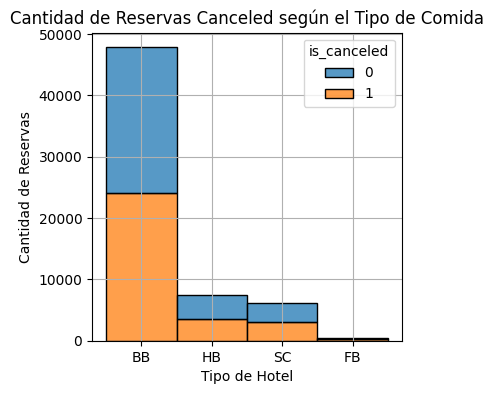

In [47]:
columns = ['meal', 'is_canceled']
data = hotels_df[columns]

sns.histplot(data=data, x='meal', hue='is_canceled', multiple='stack', legend=True)
plt.xlabel('Tipo de Hotel')
plt.ylabel('Cantidad de Reservas')
plt.grid()
plt.title('Cantidad de Reservas Canceled según el Tipo de Comida')
plt.show()

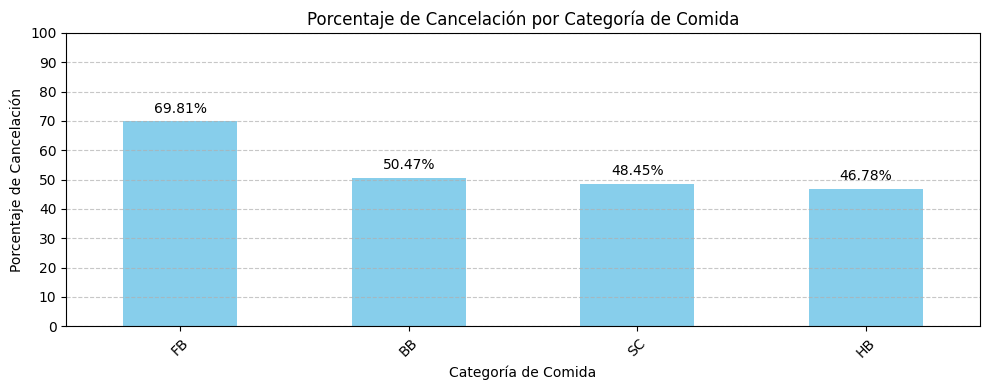

In [48]:
total_reservas_por_comida = hotels_df['meal'].value_counts()
reservas_canceladas_por_comida = hotels_df[hotels_df['is_canceled'] == 1]['meal'].value_counts()
porcentaje_cancelacion_por_comida = (reservas_canceladas_por_comida / total_reservas_por_comida) * 100
porcentaje_cancelacion_por_comida = porcentaje_cancelacion_por_comida.sort_values(ascending=False)

plt.figure(figsize=(10, 4))
ax = porcentaje_cancelacion_por_comida.plot(kind='bar', color='skyblue')
plt.title('Porcentaje de Cancelación por Categoría de Comida')
plt.xlabel('Categoría de Comida')
plt.ylabel('Porcentaje de Cancelación')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(range(0, 101, 10))

for i, v in enumerate(porcentaje_cancelacion_por_comida):
    ax.text(i, v + 2, f'{v:.2f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Regreso hotels_df a su estado original
hotels_df = hotels_df_backup.copy()

En base a los gráficos hechos, se ve que existe una pequeña relación con Target para SC, HB y FB (princpalemente para esta última), pero en FB hay en relación tan pocos datos que esta información no podrá ser utilizada generalmente. 

Aun así la relación está por lo que se considera como un parámetro **relevante** a la hora de entrenar el modelo.

#### country

El parámetro es de tipo **Variable Independiente Cualitativa Texto Nominal** ya que es una categoría, son países. En un principio, sería normal pensar que dependiendo el país haya más o menos cancelaciones de reservas puesto que la cultura influye mucho en la toma de decisiones. Se propone mostrar un gráfico de torta con los porcentajes de reserva de cada país y luego un gráfico con los porcentajes de cancelaciones.

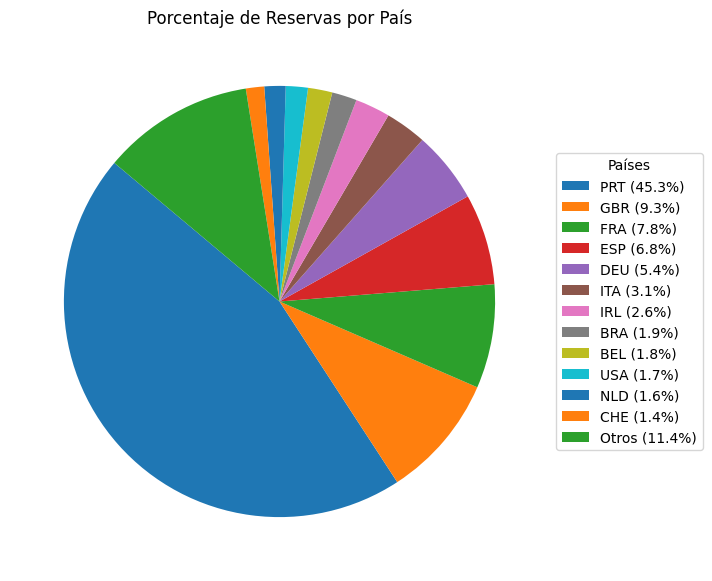

In [49]:
porcentajes_reserva_por_pais = hotels_df['country'].value_counts(normalize=True) * 100

# Filtro países con un porcentaje mayor al 1% y agrupar los demás en "Otros"
umbral = 1
porcentajes_reserva_por_pais = porcentajes_reserva_por_pais[porcentajes_reserva_por_pais > umbral]
porcentajes_reserva_por_pais['Otros'] = 100 - porcentajes_reserva_por_pais.sum()

plt.figure(figsize=(7, 7))
wedges = plt.pie(porcentajes_reserva_por_pais, startangle=140)
leyenda_personalizada = [f'{l} ({p:.1f}%)' for l, p in zip(porcentajes_reserva_por_pais.index, porcentajes_reserva_por_pais)]
plt.legend(leyenda_personalizada, title="Países", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Porcentaje de Reservas por País')
plt.show()

Como se puede observar, la mayor parte de las reservaciones provienen de Portugal (PRT), luego de Reino Unido (GBR), de Francia (FRA), España (ESP) y Alemania (DEU). Luego, los demás países en menor medida.

Además se ve que hay 221 valores faltantes. 

In [50]:
hotels_df['country'].isna().sum()

221

A continuación, se muestra en un gráfico de barras el porcentaje de cancelaciones por país:

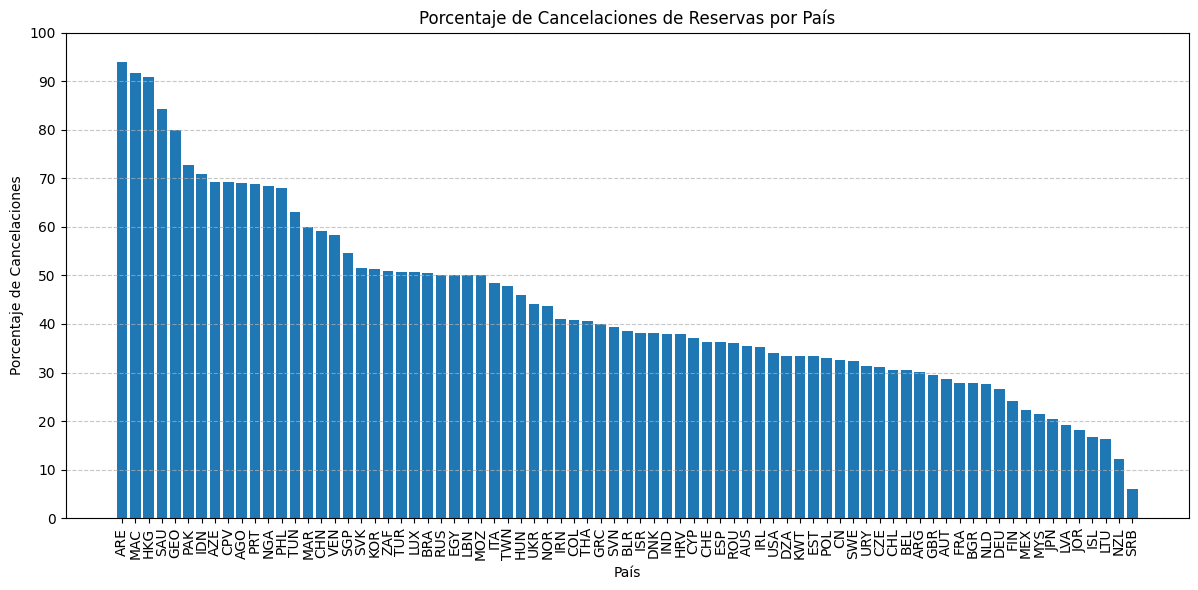

In [51]:
country_counts = hotels_df['country'].value_counts()
countries_with_more_than_10_reservations = country_counts[country_counts > 10].index
filtered_df = hotels_df[hotels_df['country'].isin(countries_with_more_than_10_reservations)]
cancelation_percentages = (filtered_df.groupby('country')['is_canceled'].mean() * 100).reset_index()
cancelation_percentages = cancelation_percentages.sort_values(by='is_canceled', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(cancelation_percentages['country'], cancelation_percentages['is_canceled'])
plt.xlabel('País')
plt.ylabel('Porcentaje de Cancelaciones')
plt.title('Porcentaje de Cancelaciones de Reservas por País')
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(range(0, 101, 10))
plt.show()

hotels_df = hotels_df_backup.copy()

Como puede observarse en el gráfico, el porcentaje de cancelación posee un porcentaje de variación muy alto dependiendo el país. Vale aclarar que se muestran países con una cantidad mayor a 10 reservas, ya que en caso contrario el gráfico era demasiado extenso y tampoco se tenía una cantidad de datos apreciable como para tener un porcentaje fiable.  
Además, como puede apreciarse, PRT (Portugal) es el país con mayor cantidad de reservas, pero no cancelaciones. Sin embargo, ARE (Emiratos Arabes Unidos), tiene menos del 1% de reservas, pero aún así guarda una tasa de cancelaciones muy alta. SRB (Serbia), por otro lado, posee pocas reservas, pero una tasa de no cancelación muy baja.

Este atributo resulta **relevante** para el entrenamiento del modelo y guarda una estrecha relación con el **target**. Con respecto a las filas que no tienen este atributo serán eliminadas.

#### market_segment

Este parámetro sirve para segmentar el mercado en grupos más pequeños y homogéneos de consumidores o empresas que comparten características similares. Es una **Variable Independiente Cualitativa Texto Nominal**.

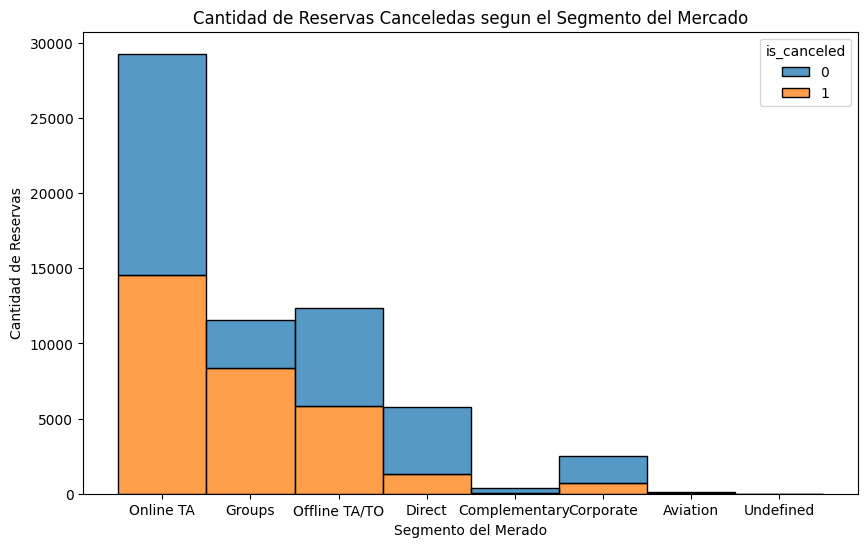

In [52]:
columns = ['market_segment', 'is_canceled']
data = hotels_df[columns]

plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='market_segment', hue='is_canceled', multiple='stack', bins=9, legend=True)
plt.xlabel('Segmento del Merado')
plt.ylabel('Cantidad de Reservas')
plt.title('Cantidad de Reservas Canceledas segun el Segmento del Mercado')
plt.show()

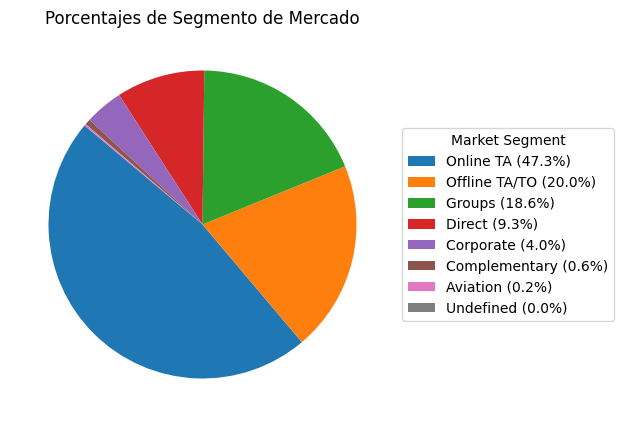

In [53]:
porcentajes_reserva_por_dc = hotels_df['market_segment'].value_counts(normalize=True) * 100

plt.figure(figsize=(7, 5))
wedges = plt.pie(porcentajes_reserva_por_dc, startangle=140)
leyenda_personalizada = [f'{l} ({p:.1f}%)' for l, p in zip(porcentajes_reserva_por_dc.index, porcentajes_reserva_por_dc)]
plt.legend(leyenda_personalizada, title="Market Segment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Porcentajes de Segmento de Mercado')
plt.show()

Como se puede observar, la mayor parte de las reservas provienen de TA Online, luego de Offline TA/TO, seguido por Groups y luego por Direct. Finalmente, los demás en menor medida. Undefined indicaría que habría que revisar dichos valores.

Se propone ahora analizar su relación con target en un gráfico de barras porcentuales con respecto a la cantidad de cancelaciones:

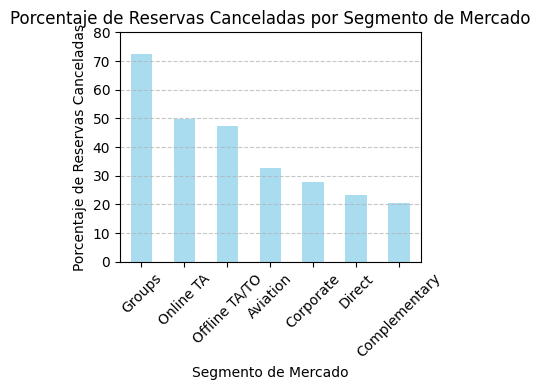

In [54]:
segment_cancelation_percentage = hotels_df[hotels_df['market_segment'] !='Undefined']\
    .groupby('market_segment')['is_canceled'].mean() * 100
segment_cancelation_percentage = segment_cancelation_percentage.sort_values(ascending=False)

plt.figure()
segment_cancelation_percentage.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Porcentaje de Reservas Canceladas por Segmento de Mercado')
plt.xlabel('Segmento de Mercado')
plt.ylabel('Porcentaje de Reservas Canceladas')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(range(0, 81, 10))
plt.tight_layout()
plt.show()

Como se puede observar, hay mucha diferencia según el grupo, particularmente para la categoría Groups, por lo que está fuertemente relacionada con la variable **target** y es **relevante** para el entrenamiento del modelo.

La cantidad de entradas con _market_segment_ con valores faltantes (no definidos) es despreciable, estas filas serán eliminadas.

#### distribution_channel

Este parámetro sigue la misma lógica de análisis que el anterior, es una **Variable Independiente Cualitativa Texto Nominal**.

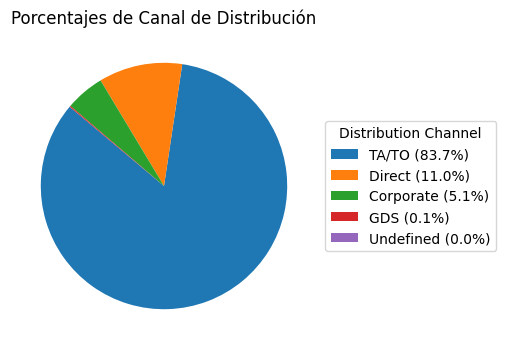

In [55]:
porcentajes_reserva_por_dch = hotels_df['distribution_channel'].value_counts(normalize=True) * 100

plt.figure(figsize=(7, 4))
wedges, labels = plt.pie(porcentajes_reserva_por_dch, startangle=140)
leyenda_personalizada = [f'{l} ({p:.1f}%)' for l, p in zip(porcentajes_reserva_por_dch.index, porcentajes_reserva_por_dch)]
plt.legend(leyenda_personalizada, title="Distribution Channel", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Porcentajes de Canal de Distribución')
plt.show()

Claramente, se puede apreciar que la mayor parte de las reservas provienen de TA/TO, luego de Direct y finalmente de Corporate. Por último, de GDS y Undefined. Se propone verificar los porcentajes de cancelación en un gráfico de barras para estudiar su relación con target.

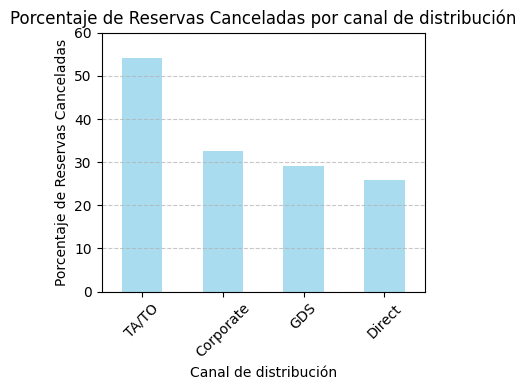

In [56]:
dc_cancelation_percentage = hotels_df[hotels_df['distribution_channel'] !='Undefined']\
    .groupby('distribution_channel')['is_canceled'].mean() * 100

dc_cancelation_percentage = dc_cancelation_percentage.sort_values(ascending=False)

plt.figure()
dc_cancelation_percentage.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Porcentaje de Reservas Canceladas por canal de distribución')
plt.xlabel('Canal de distribución')
plt.ylabel('Porcentaje de Reservas Canceladas')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(range(0, 61, 10))
plt.tight_layout()
plt.show()

Sin tener en cuenta "Undefined", se puede apreciar un porcentaje mucho mayor de cancelación de TA/TO (Travel Agent) con respecto a los demás. Por lo que se puede afirmar que guarda una relación estrecha con **target** y es **relevante**. Las filas que no tienen este atributo serán eliminadas (son 4).

#### is_repeated_guest

Este parámetro indica si el cliente ha visitado el hotel en el pasado o no. Es una **Variable Independiente Cuantitativa Numérica Nominal**, que es un valor binario, que indica 1 como _true_ y 0 como _false_.

Se propone buscar la relación con las cancelaciones y el porcentaje de clientes repetidos.

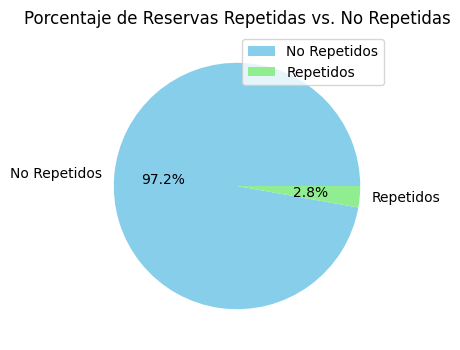

In [57]:
guest_counts = hotels_df['is_repeated_guest'].value_counts()

plt.figure(figsize=(8, 4))
plt.pie(guest_counts, labels=['No Repetidos', 'Repetidos'], autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
plt.legend(loc="upper right")
plt.title('Porcentaje de Reservas Repetidas vs. No Repetidas')
plt.show()

El porcentaje de visitantes Repetidos es mucho menor al de No Repetidos, pero esto no significa que no deba tenerse en cuenta. Se propone investigar su relación con la variable target:

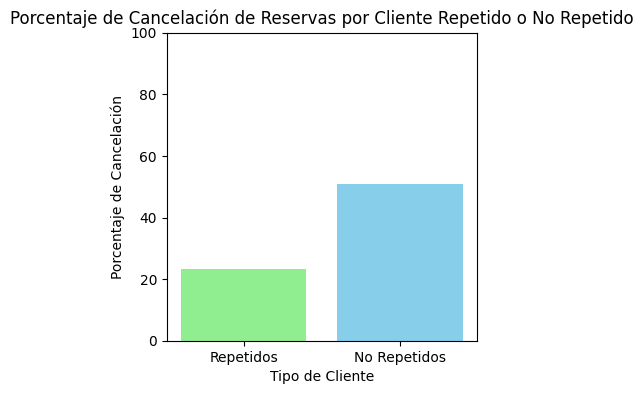

In [58]:
repeated_guests_df = hotels_df[hotels_df['is_repeated_guest'] == 1]
non_repeated_guests_df = hotels_df[hotels_df['is_repeated_guest'] == 0]
cancelation_percentage_repeated = (repeated_guests_df['is_canceled'].mean()) * 100
cancelation_percentage_non_repeated = (non_repeated_guests_df['is_canceled'].mean()) * 100
categories = ['Repetidos', 'No Repetidos']
cancelation_percentages = [cancelation_percentage_repeated, cancelation_percentage_non_repeated]

plt.figure()
plt.bar(categories, cancelation_percentages, color=['lightgreen', 'skyblue'])
plt.ylim(0, 100)
plt.title('Porcentaje de Cancelación de Reservas por Cliente Repetido o No Repetido')
plt.xlabel('Tipo de Cliente')
plt.ylabel('Porcentaje de Cancelación')
plt.show()

Como puede observarse, es mucho menor la probabilidad de que un cliente que ya vino al hotel cancele su reserva a que lo haga uno que no repitió. Entonces, el parámetro es **relevante** y guarda una relación estrecha con el parámetro **target**.

#### previous_cancellations

Este parámetro es similar al anterior en cuanto análisis, es una **Variable Independiente Cualitativa Numérica Nominal**.

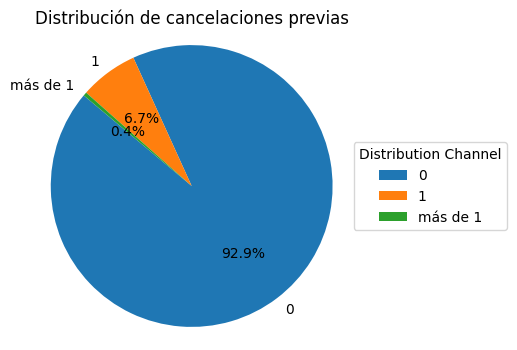

In [59]:
previous_cancellations = hotels_df['previous_cancellations'].copy()
previous_cancellations = previous_cancellations.apply(lambda x: x if x <= 1 else 'más de 1')
cancellation_counts = previous_cancellations.value_counts()

plt.figure(figsize=(4, 4))
plt.pie(cancellation_counts, labels=cancellation_counts.index, autopct='%1.1f%%', startangle=140)
plt.legend(title="Distribution Channel", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Distribución de cancelaciones previas')
plt.axis('equal')
plt.show()

hotels_df = hotels_df_backup.copy()

Como puede observarse, la mayor parte de las reservas no tenían cancelaciones previas.

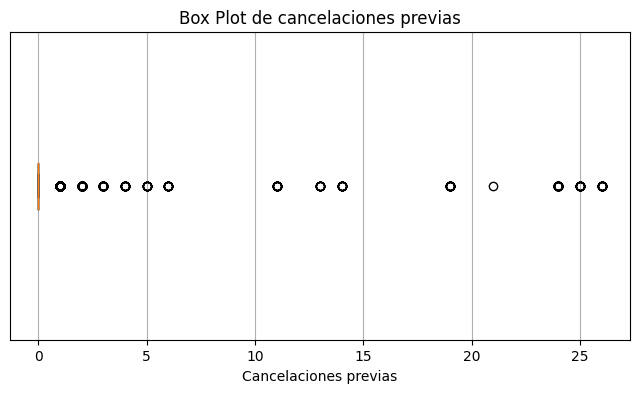

In [60]:
plt.figure(figsize=(8,4))
plt.boxplot(hotels_df['previous_cancellations'], vert=False)
plt.xlabel('Cancelaciones previas')
plt.xticks(range(0, 30, 5))
plt.grid(axis='x')
plt.yticks([])
plt.title('Box Plot de cancelaciones previas')
plt.show()

Se puede observar que la gran mayoría de usuarios no tuvo reservas canceladas previamente.

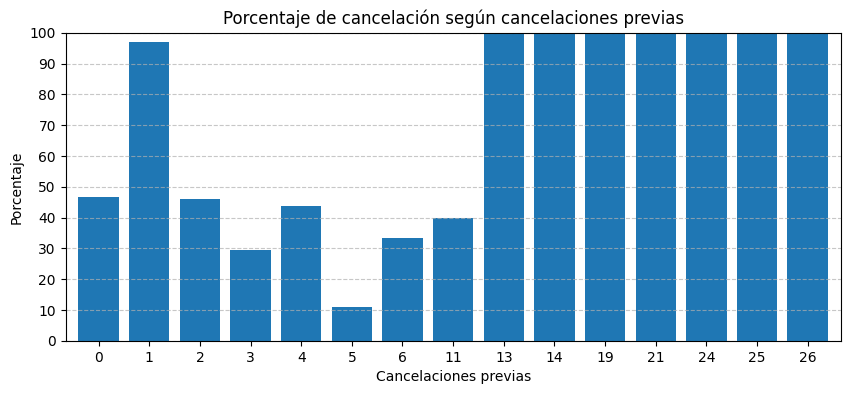

In [61]:
hotels_df = hotels_df_backup.copy()
cancellation_percentages = hotels_df.groupby('previous_cancellations')['is_canceled'].mean() * 100

plt.figure(figsize=(10, 4))
cancellation_percentages.plot(kind='bar', width=0.8)
plt.title('Porcentaje de cancelación según cancelaciones previas')
plt.xlabel('Cancelaciones previas')
plt.ylabel('Porcentaje')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(range(0, 101, 10))
plt.ylim(0, 100)
plt.show()

El porcentaje de cancelación aumenta si el usuario tuvo una cancelación previa y para cantidades mayores a una, el porcentaje de la muestra resulta despreciable.

Se considera que es una variable **relevante** y está relacionada con el **target**.

#### is_repeated_guest

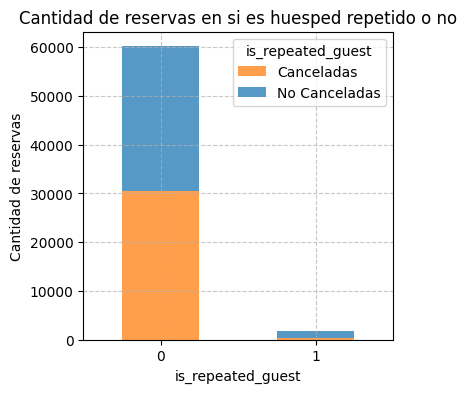

In [62]:
reservas = hotels_df.groupby(['is_repeated_guest', 'is_canceled']).size().unstack()
reservas = reservas[[1, 0]]

reservas.plot(kind='bar', stacked=True,  color=['#FF9F4B', '#5799C6'])
plt.title('Cantidad de reservas en si es huesped repetido o no')
plt.ylabel('Cantidad de reservas')
plt.legend(loc='upper right', title='is_repeated_guest', labels=['Canceladas', 'No Canceladas'])
plt.grid(linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.show()

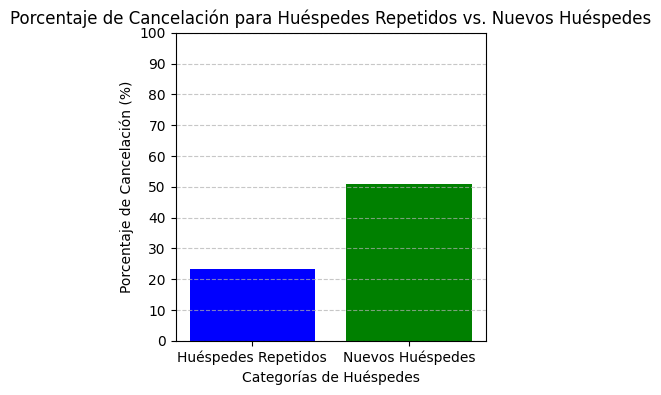

In [63]:
repeated_guests = hotels_df[hotels_df['is_repeated_guest'] != 0]
new_guests = hotels_df[hotels_df['is_repeated_guest'] == 0]
percentage_repeated_guest = (repeated_guests['is_canceled'].sum() / len(repeated_guests)) * 100
percentage_new_guest = (new_guests['is_canceled'].sum() / len(new_guests)) * 100

data = {'Porcentaje': [percentage_repeated_guest, percentage_new_guest]}
categorias = ['Huéspedes Repetidos', 'Nuevos Huéspedes']
df = pd.DataFrame(data, index=categorias)

plt.figure()
plt.bar(df.index, df['Porcentaje'], color=['blue', 'green'])
plt.xlabel('Categorías de Huéspedes')
plt.ylabel('Porcentaje de Cancelación (%)')
plt.title('Porcentaje de Cancelación para Huéspedes Repetidos vs. Nuevos Huéspedes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(range(0, 101, 10))
plt.show()

Como se puede observar, el porcentaje de cancelación de los huéspedes que ya visitaron el hotel es mucho menor a los nuevos huéspedes que nunca lo hicieron, esto puede deberse a que ya entablaron una relación con la gente del hotel, o tal vez se sienten más seguros y no quieren perder dicha relación u otra razón. Aun así se tiene que tener en cuenta que no hay demasiadas muestras con huéspedes repetidos. Es **relevante** para el entrenamiento del modelo y tiene un fuerte relación con el **target**.

#### previous_bookings_not_canceled

Es una **Variable Independiente Cualitativa Numérica Nominal**

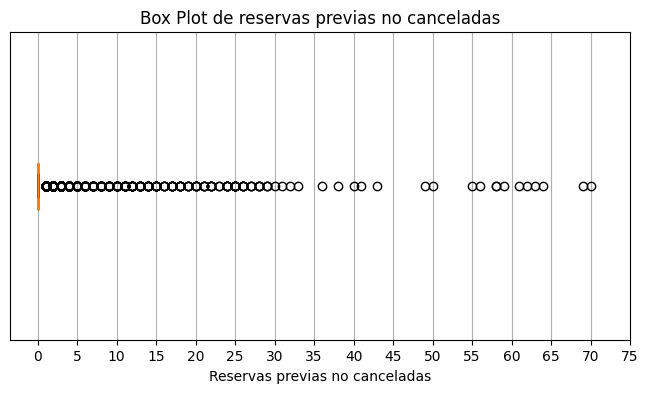

In [64]:
plt.figure(figsize=(8,4))
plt.boxplot(hotels_df['previous_bookings_not_canceled'], vert=False)
plt.xlabel('Reservas previas no canceladas')
plt.xticks(range(0, 80, 5))
plt.grid(axis='x')
plt.yticks([])
plt.title('Box Plot de reservas previas no canceladas')
plt.show()

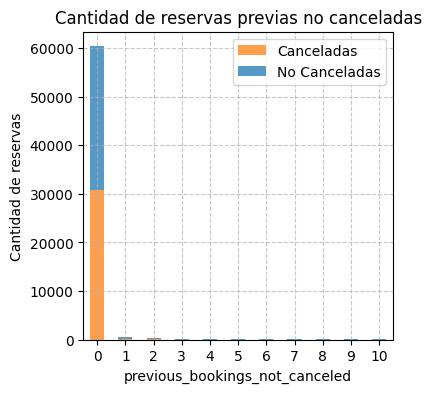

In [65]:
reservas = hotels_df.groupby(['previous_bookings_not_canceled', 'is_canceled']).size().unstack()
reservas = reservas[[1, 0]]

reservas.plot(kind='bar', stacked=True,  color=['#FF9F4B', '#5799C6'])
plt.xlim(-0.5,10.5)
plt.title('Cantidad de reservas previas no canceladas')
plt.ylabel('Cantidad de reservas')
plt.legend(loc='upper right', labels=['Canceladas', 'No Canceladas'])
plt.grid(linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.show()

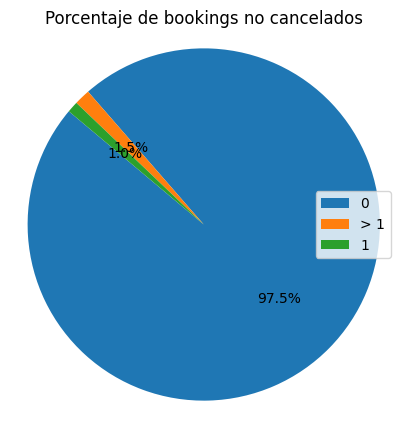

In [66]:
previous_cancellations = hotels_df['previous_bookings_not_canceled'].copy()
previous_cancellations = previous_cancellations.apply(lambda x: x if x <= 1 else '> 1')
cancellation_counts = previous_cancellations.value_counts()

plt.figure(figsize=(5, 5))
plt.pie(cancellation_counts, autopct='%1.1f%%', startangle=140)
plt.legend(cancellation_counts.index, loc="center right")
plt.title('Porcentaje de bookings no cancelados')
plt.axis('equal')
plt.show()

hotels_df = hotels_df_backup.copy()

Se representa la cantidad de reservas previas que un cliente o grupo de clientes ha realizado en un hotel específico y que no fueron canceladas

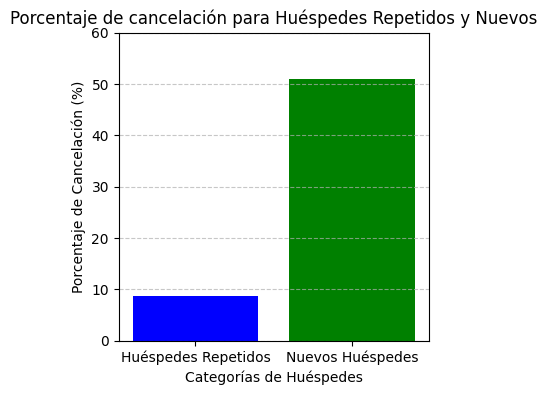

In [67]:
repeated_guests = hotels_df[hotels_df['previous_bookings_not_canceled'] != 0]
new_guests = hotels_df[hotels_df['previous_bookings_not_canceled'] == 0]
percentage_repeated_guest = (repeated_guests['is_canceled'].sum() / len(repeated_guests)) * 100
percentage_new_guest = (new_guests['is_canceled'].sum() / len(new_guests)) * 100

data = {'Porcentaje': [percentage_repeated_guest, percentage_new_guest]}
categorias = ['Huéspedes Repetidos', 'Nuevos Huéspedes']
df = pd.DataFrame(data, index=categorias)

plt.figure()
plt.bar(df.index, df['Porcentaje'], color=['blue', 'green'])
plt.xlabel('Categorías de Huéspedes')
plt.ylabel('Porcentaje de Cancelación (%)')
plt.title('Porcentaje de cancelación para Huéspedes Repetidos y Nuevos')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(range(0, 61, 10))
plt.ylim(0, 60)
plt.show()

Es mucho más probable que un huesped que nunca reservó un booking cancele que uno que ya lo hizo, esto puede deberse a que ya entabló una relación con el establecimiento o la companía y no quiere perderlo. Hayque tener en cuenta que hay pocas muestras para huéspedes repetidos así que probablemente este atributo por sí solo no sirva para armar un buen modelo. Entonces, se puede deducir que es un parámetro **relevante** y está relacionado con el **target**.

#### reserved_room_type

Este parámetro es una **Variable Independiente Cualitativa Nominal** que indica el tipo de cuarto reservado. A partir de dicho valor se propone investigar el porcentaje de reservas por cuarto y el porcentaje de cancelación dependiendo el cuarto reservado.

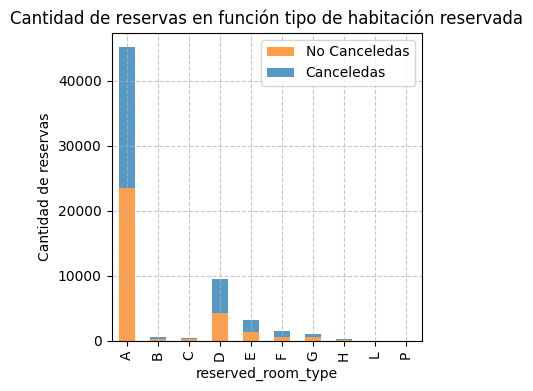

In [68]:
reservas = hotels_df.groupby(['reserved_room_type', 'is_canceled']).size().unstack()
reservas = reservas[[1, 0]]

reservas.plot(kind='bar', stacked=True,  color=['#FF9F4B', '#5799C6'])
plt.title('Cantidad de reservas en función tipo de habitación reservada')
plt.ylabel('Cantidad de reservas')
plt.legend(labels=['No Canceledas', 'Canceledas'])
plt.grid(linestyle='--', alpha=0.7)
plt.show()

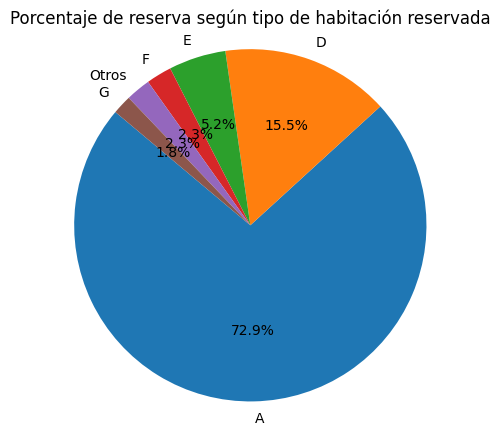

In [69]:
hotels_df_copy = hotels_df.copy()
reserved_room_type_counts = hotels_df_copy["reserved_room_type"].value_counts()
threshold = 0.01 * len(hotels_df_copy)
hotels_df_copy['reserved_room_type'] = hotels_df_copy['reserved_room_type'].apply(lambda x: x if reserved_room_type_counts[x] > threshold else 'Otros')
new_reserved_room_type_counts = hotels_df_copy['reserved_room_type'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(new_reserved_room_type_counts, labels=new_reserved_room_type_counts.index, autopct='%1.1f%%', startangle=140)

plt.title('Porcentaje de reserva según tipo de habitación reservada')
plt.axis('equal')
plt.show()

hotels_df = hotels_df_backup.copy()

Como se puede apreciar, la mayor parte de las reservas eligen el cuarto A y tiene un costo menor, las otras reservas serán más caras a medida que la letra sea "mayor". Ahora su relación con respecto al target

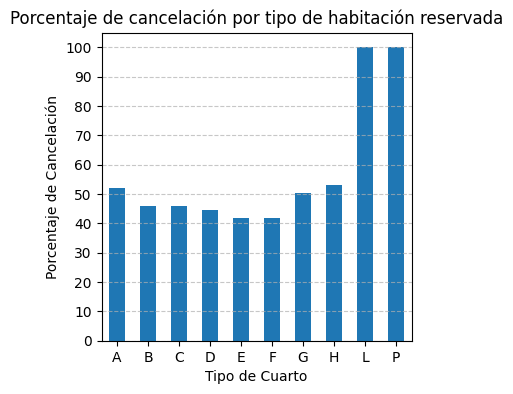

In [70]:
reserved_room_type_counts = hotels_df["reserved_room_type"].value_counts()
threshold = 0.01 * len(hotels_df)
cancellation_percentages = hotels_df.groupby('reserved_room_type')['is_canceled'].mean() * 100

plt.figure()
cancellation_percentages.plot(kind='bar')
plt.title('Porcentaje de cancelación por tipo de habitación reservada')
plt.xlabel('Tipo de Cuarto')
plt.ylabel('Porcentaje de Cancelación')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(range(0, 101, 10))
plt.show()

hotels_df = hotels_df_backup.copy()

Si bien se puede apreciar cierta variación entre los cuartos, no se ve una relación muy estrecha, por lo que se puede concluir que es **irrelevante** para el entrenamiento del modelo. Además, no posee una relación tan estrecha con el **target**.

#### assigned_room_type

Este parámetro indica el cuarto que efectivamente se asignó, a veces difiere del original, por lo que, se propone investigar la cantidad de cuartos que difieren entre el assigned_room_type y a partir de dicho dato, calcular la cantidad de cancelaciones. Es una **Variable Dependiente Cualitativa Texto Nominal**.

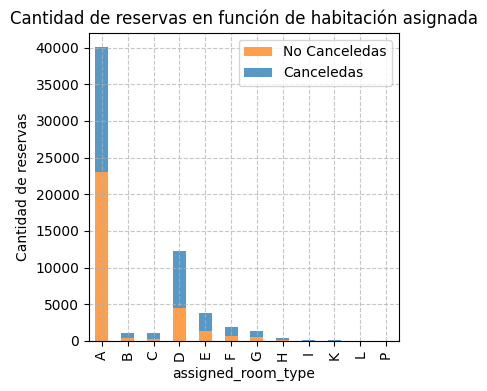

In [71]:
reservas = hotels_df.groupby(['assigned_room_type', 'is_canceled']).size().unstack()
reservas = reservas[[1, 0]]

reservas.plot(kind='bar', stacked=True,  color=['#FF9F4B', '#5799C6'])
plt.title('Cantidad de reservas en función de habitación asignada')
plt.ylabel('Cantidad de reservas')
plt.legend(labels=['No Canceledas', 'Canceledas'])
plt.grid(linestyle='--', alpha=0.7)
plt.show()

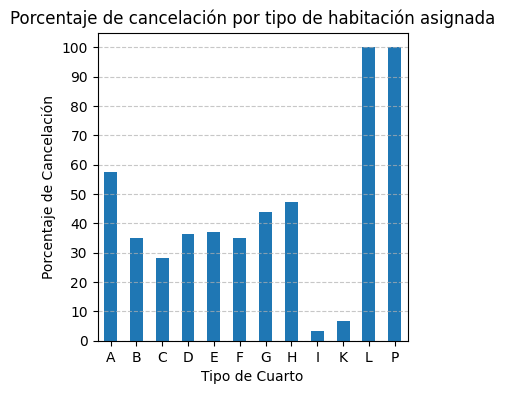

In [72]:
reserved_room_type_counts = hotels_df["assigned_room_type"].value_counts()
cancellation_percentages = hotels_df.groupby('assigned_room_type')['is_canceled'].mean() * 100

plt.figure()
cancellation_percentages.plot(kind='bar')
plt.title('Porcentaje de cancelación por tipo de habitación asignada')
plt.xlabel('Tipo de Cuarto')
plt.ylabel('Porcentaje de Cancelación')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(range(0, 101, 10))
plt.show()

hotels_df = hotels_df_backup.copy()

En base a los gráficos, se ve que es una variable **relevante** y relacionada con **Target** dado a que varía de manera considerable el porcentaje de cancelación en base al tipo de habitación asignada. Incluso si hay habitaciones sin una gran cantidad de muestras, la mayor cantidad es de tipo A y tiene un porcentaje de cancelación del 58% aproximadamente.

#### Habitación asignada es la pedida

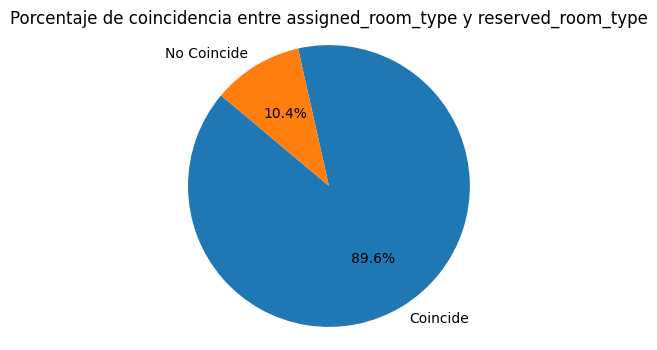

In [73]:
hotels_df_copy = hotels_df.copy()
hotels_df_copy['room_type_match'] = hotels_df_copy['assigned_room_type'] == hotels_df_copy['reserved_room_type']
match_counts = hotels_df_copy['room_type_match'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(match_counts, labels=['Coincide', 'No Coincide'], autopct='%1.1f%%', startangle=140)
plt.title('Porcentaje de coincidencia entre assigned_room_type y reserved_room_type')
plt.axis('equal')
plt.show()

El porcentaje de No Coincidencia es bastante alto (un 10%), por lo que podría suceder que al no asignar el cuarto esperado, el cliente cancele la reserva. Esto merece ser estudiado, tal que se compararán los porcentajes de cancelación de las coincidencias y las no coincidencias.

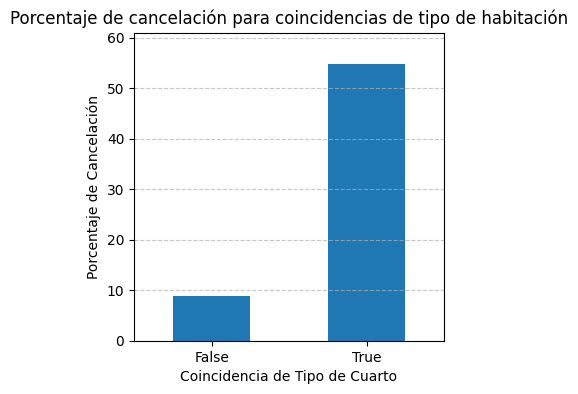

In [74]:
hotels_df_copy = hotels_df.copy()
hotels_df_copy['room_type_match'] = hotels_df_copy['assigned_room_type'] == hotels_df_copy['reserved_room_type']
cancellation_percentages = hotels_df_copy.groupby('room_type_match')['is_canceled'].mean() * 100

plt.figure()
cancellation_percentages.plot(kind='bar')
plt.title('Porcentaje de cancelación para coincidencias de tipo de habitación')
plt.xlabel('Coincidencia de Tipo de Cuarto')
plt.ylabel('Porcentaje de Cancelación')
plt.xticks([0, 1], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(range(0, 61, 10))
plt.ylim(0, 61)
plt.show()

Al revés de lo que se esperaba, si la habitación pedida no coincide con la asignada, el porcentaje de cancelación es considerablemente menor. Una posible explicación sería que los hoteles tengan una politica de reservarles un mejor cuarto si no esta disponible el cuarto pedido. Claramente esta nueva comparación es **relevante** para el entrenamiento del modelo, así mismo se ve su relación con la variable **target**.

#### booking_changes

Este parámetro es una **Variable Independiente Cuantitativa Discreta**, tal que indica la cantidad de cambios realizados en el booking, por el cliente o la empresa.

In [75]:
parameter_column = hotels_df['booking_changes'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a target): ", covarianza)
print("Correlación de Pearson (con respecto a target): ", pearson)

Media:  0.19595238479802304
Mediana:  0.0
Varianza:  0.3727279516035467
Desviación Estandar:  0.6105144974556679
Moda:  0
Covarianza (con respecto a target):  -0.04863294253191035
Correlación de Pearson (con respecto a target):  -0.15931534247315668


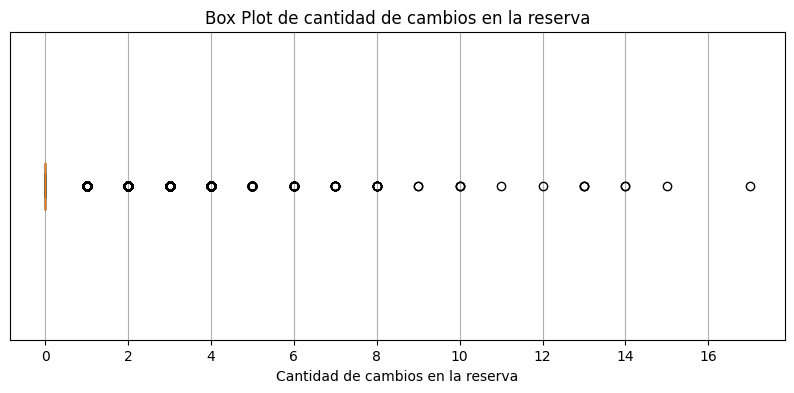

In [76]:
plt.figure(figsize=(10, 4))
plt.boxplot(hotels_df['booking_changes'], vert=False)
plt.xlabel('Cantidad de cambios en la reserva')
plt.xticks(range(0, 18, 2))
plt.grid(axis='x')
plt.yticks([])

plt.title('Box Plot de cantidad de cambios en la reserva')
plt.show()

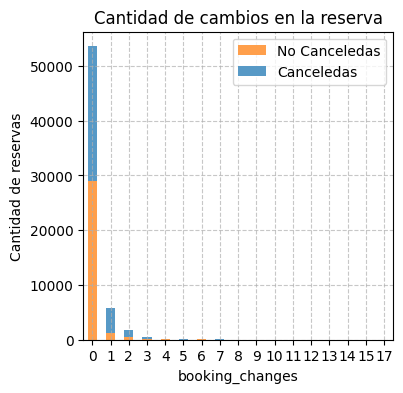

In [77]:
reservas = hotels_df.groupby(['booking_changes', 'is_canceled']).size().unstack()
reservas = reservas[[1, 0]]

reservas.plot(kind='bar', stacked=True,  color=['#FF9F4B', '#5799C6'])
plt.title('Cantidad de cambios en la reserva')
plt.ylabel('Cantidad de reservas')
plt.legend(labels=['No Canceledas', 'Canceledas'])
plt.grid(linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.show()

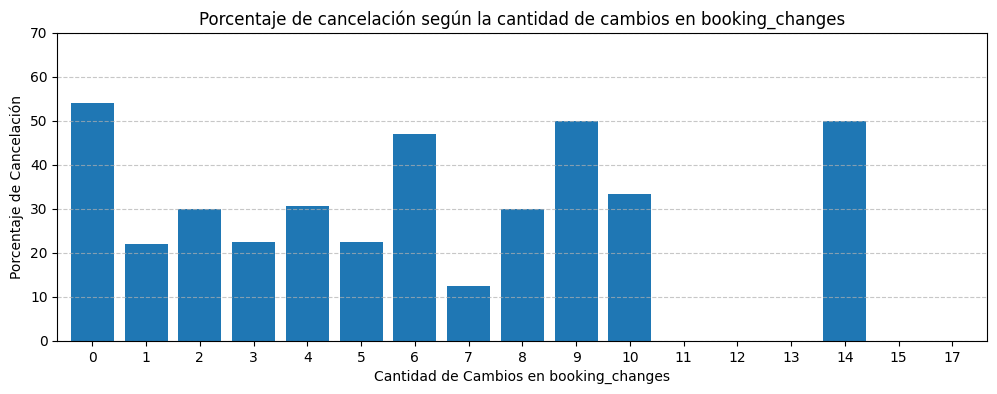

In [78]:
hotels_df_copy = hotels_df.copy()
cancellation_percentages = hotels_df_copy.groupby('booking_changes')['is_canceled'].mean() * 100

plt.figure(figsize=(12, 4))
cancellation_percentages.plot(kind='bar', width=0.8)
plt.title('Porcentaje de cancelación según la cantidad de cambios en booking_changes')
plt.xlabel('Cantidad de Cambios en booking_changes')
plt.ylabel('Porcentaje de Cancelación')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(range(0, 71, 10))
plt.ylim(0, 70)
plt.show()

Siendo que la mayoría de las reservas son sin cambios, se busca analizar el caso booleano de si hubo o no cambios, en vez de la cantidad de estos.

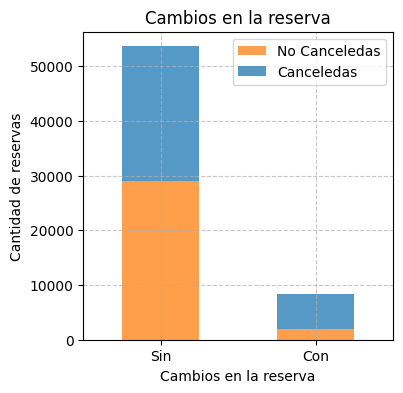

In [79]:
hotels_df_copy = hotels_df.copy()
hotels_df_copy['more_than_one_change'] = hotels_df_copy['booking_changes'] != 0
change_counts = hotels_df_copy['more_than_one_change'].value_counts()

reservas = hotels_df_copy.groupby(['more_than_one_change', 'is_canceled']).size().unstack()
reservas = reservas[[1, 0]]

reservas.plot(kind='bar', stacked=True,  color=['#FF9F4B', '#5799C6'])
plt.title('Cambios en la reserva')
plt.xlabel('Cambios en la reserva')
plt.ylabel('Cantidad de reservas')
plt.legend(labels=['No Canceledas', 'Canceledas'])
plt.grid(linestyle='--', alpha=0.7)
plt.xticks([0,1], ['Sin', 'Con'], rotation=0)
plt.show()

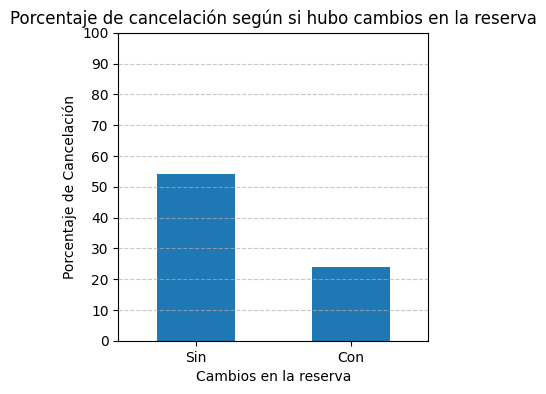

In [80]:
hotels_df_copy = hotels_df.copy()
hotels_df_copy['changes_occurred'] = hotels_df_copy['booking_changes'] > 0
cancellation_percentages = hotels_df_copy.groupby('changes_occurred')['is_canceled'].mean() * 100

plt.figure()
cancellation_percentages.plot(kind='bar')
plt.title('Porcentaje de cancelación según si hubo cambios en la reserva')
plt.xlabel('Cambios en la reserva')
plt.ylabel('Porcentaje de Cancelación')
plt.xticks([0, 1], ['Sin', 'Con'], rotation=0)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(range(0, 101, 10))
plt.show()

Analizando los gráficos que consideran la cantidad de cambos y los de si hubo cambios, se ve que es más útil considerar directamente si una reserva tuvo cambios o no en vez de cuántos tuvo. 

Se ve claramente que hay una relación con el **target**, por lo tanto será un atributo **relevante**.

#### deposit_type

Según el paper acerca de estos datos, este parámetro indica si el cliente pagó una parte, el total o nada de la reserva. Es una **Variable Independiente Cualitativa Texto Nominal**

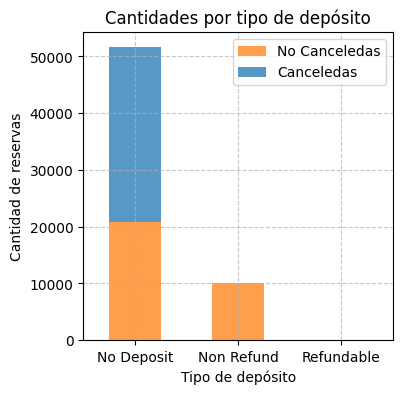

In [81]:
reservas = hotels_df.groupby(['deposit_type', 'is_canceled']).size().unstack()
reservas = reservas[[1, 0]]

reservas.plot(kind='bar', stacked=True,  color=['#FF9F4B', '#5799C6'])
plt.title('Cantidades por tipo de depósito')
plt.xlabel('Tipo de depósito')
plt.ylabel('Cantidad de reservas')
plt.legend(labels=['No Canceledas', 'Canceledas'])
plt.grid(linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.show()

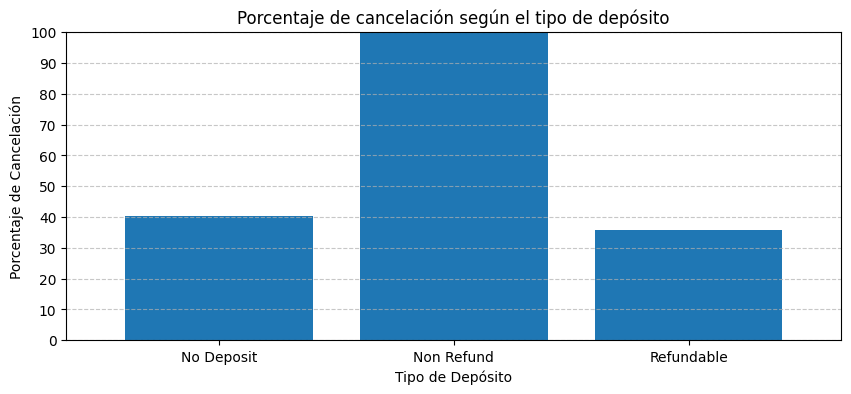

In [82]:
hotels_df_copy = hotels_df.copy()
cancellation_percentages = hotels_df_copy.groupby('deposit_type')['is_canceled'].mean() * 100

plt.figure(figsize=(10, 4))
cancellation_percentages.plot(kind='bar', width=0.8)
plt.title('Porcentaje de cancelación según el tipo de depósito')
plt.xlabel('Tipo de Depósito')
plt.ylabel('Porcentaje de Cancelación')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(range(0, 101, 10))
plt.ylim(0, 100)
plt.show()

Como se puede observar, todas las reservas con el depósito tipo Non Refund fueron canceladas, además se ve que hay una muestra muy considerable para este tipo. Al tipo No Deposit tiene un porcentaje de cancelación del 40%, por lo que también es información útil. 

Este parámetro es **relevante** para predecir si una reserva será cancelada, guarda relación estrecha con el **target**.

#### agent

El parámetro agent es un identificador que relaciona la agencia de viajes con la reserva. Es una **Variable Independiente Cualitativa de Texto Nominal**.

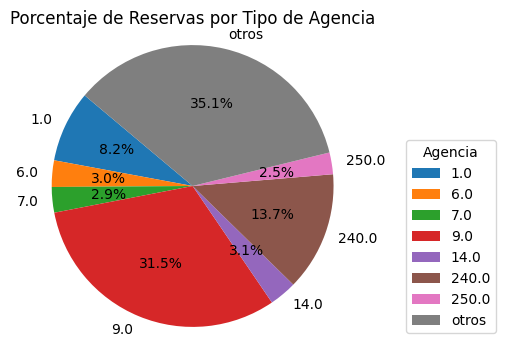

In [83]:
agent_count_df = hotels_df["agent"].value_counts().sort_index()

mask = agent_count_df > 1000

insigValues = agent_count_df[~mask].sum()
agent_count_df = agent_count_df[mask]
agent_count_df.loc["otros"] = insigValues

plt.figure()
agent_count_df.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Porcentaje de Reservas por Tipo de Agencia')
plt.axis('equal')
plt.ylabel('')
plt.legend(title="Agencia", loc="lower right", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

En el gráfico pastel se muestran las agencias que hicieron al menos 1000 reservas y se agrupan todas las que hicieron menos en el grupo "otros".

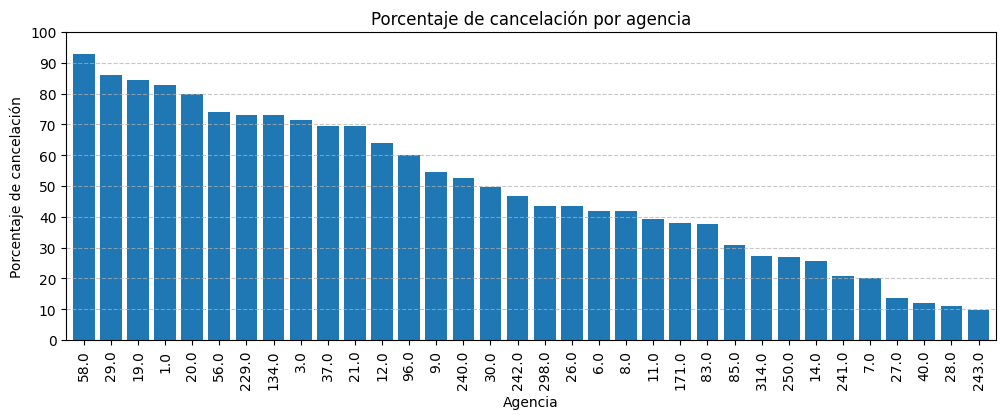

In [84]:
hotels_df_copy = hotels_df.copy()
cancellation_percentages = hotels_df_copy.groupby('agent')['is_canceled'].mean() * 100

# Propongo un mínimo de reservas para comparar, en este caso 200
min_reservations = 200
agencies_with_min_reservations = hotels_df_copy['agent'].value_counts() >= min_reservations
cancellation_percentages = cancellation_percentages[agencies_with_min_reservations]
cancellation_percentages = cancellation_percentages.sort_values(ascending=False)

plt.figure(figsize=(12, 4))
cancellation_percentages.plot(kind='bar', width=0.8)
plt.title('Porcentaje de cancelación por agencia')
plt.xlabel('Agencia')
plt.ylabel('Porcentaje de cancelación')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(range(0, 101, 10))
plt.ylim(0, 100)
plt.show()

In [85]:
nan_count = hotels_df['agent'].isna().sum()
non_nan_count = hotels_df_copy['agent'].count()
total_count = nan_count + non_nan_count
round_n = round((nan_count / total_count) * 100, 2)

print("Cantidad de valores vacíos en la columna agent: ", nan_count)
print("Porcentaje de valores vacíos en la columna agent: ", round_n,"%")

Cantidad de valores vacíos en la columna agent:  7890
Porcentaje de valores vacíos en la columna agent:  12.74 %


Como se puede observar, el ID de la agencia relacionado con el porcentaje de cancelación es muy variable dependiendo la agencia. 
Tal vez esto se debe a algún problema con la empresa en el momento que ahora puede haber cambiado su situación. Resulta **relevante** y está relacionado con el **target**.
Vale aclarar que hay muchos valores vacíos (NaN), pero en comparación con el total puede despreciarse como exploración inicial. No se hará nada con respecto a los valores faltantes de este atributo.

#### company

De manera similar al anterior parámetro, es una **Variable Independiente Cualitativa Texto Nominal**. Se presentan un gráfico pastel para mostrar el porcentaje de ventas de las mayores companías, para un mínimo de 100 reservas:

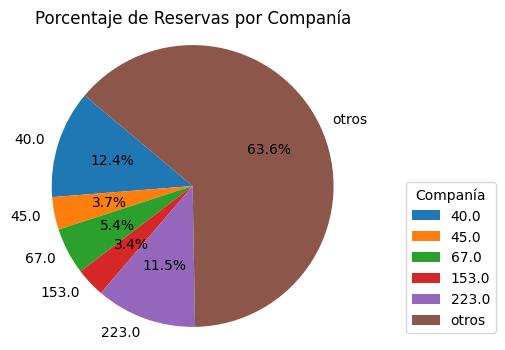

In [86]:
count_df = hotels_df["company"].value_counts().sort_index()

mask = count_df > 100

insigValues = count_df[~mask].sum()
count_df = count_df[mask]
count_df.loc["otros"] = insigValues

plt.figure()
count_df.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Porcentaje de Reservas por Companía')
plt.axis('equal')
plt.ylabel('')
plt.legend(title="Companía", loc="lower right", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

De forma análoga a la agencia, ahora se presentan los porcentajes de cancelación:

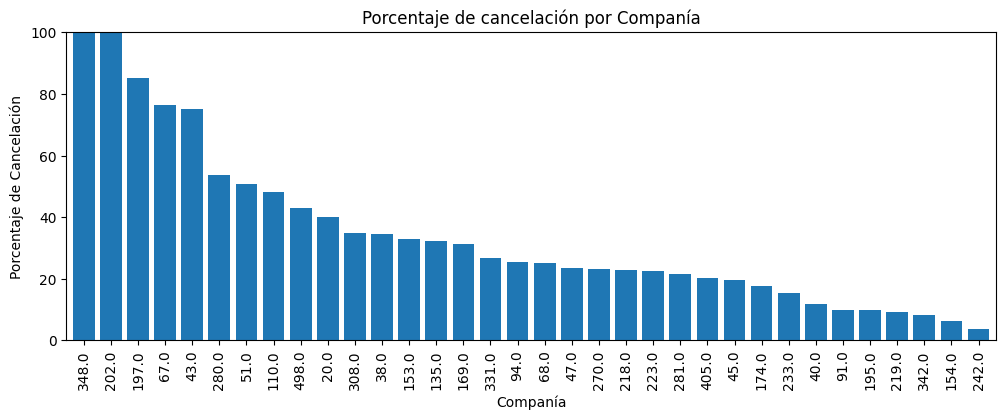

In [87]:
hotels_df_copy = hotels_df.copy()
cancellation_percentages = hotels_df_copy.groupby('company')['is_canceled'].mean() * 100

min_reservations = 20
agencies_with_min_reservations = hotels_df_copy['company'].value_counts() >= min_reservations
cancellation_percentages = cancellation_percentages[agencies_with_min_reservations]
cancellation_percentages = cancellation_percentages.sort_values(ascending=False)

plt.figure(figsize=(12, 4))
cancellation_percentages.plot(kind='bar', width=0.8)
plt.title('Porcentaje de cancelación por Companía')
plt.xlabel('Companía')
plt.ylabel('Porcentaje de Cancelación')
plt.xticks(rotation=90)
plt.ylim(0, 100)
plt.show()

In [88]:
nan_count = hotels_df['company'].isna().sum()
non_nan_count = hotels_df_copy['company'].count()
total_count = nan_count + non_nan_count
round_n = round((nan_count / total_count) * 100, 2)


print("Cantidad de valores vacíos en la columna 'company': ", nan_count)
print("Porcentaje de valores vacíos con respecto al total en la columna 'company': ", round_n, "%")

Cantidad de valores vacíos en la columna 'company':  58761
Porcentaje de valores vacíos con respecto al total en la columna 'company':  94.91 %


Como puede observarse varía mucho dependiendo la companía, aunque en los datos hay muchos valores vacíos o NaN; por lo que se sugiere no tener en cuenta esta columna y eliminarla en el futuro. De esta manera, lo mejor es considerarla **irrelevante** y no apta para relacionarla con el **target**, ya que su porcentaje de valores vacíos es mayor al 90%.

Siendo que la consideramos irrelevante, no vale la pena tomar una decisión sobre qué hacer con sus valores faltantes.

#### days_in_waiting_list

Este parámetro indica la cantidad de días que estuvo en la lista de espera la reserva. Es una **Variable Independiente Cuantitativa Discreta**, es una discretización del tiempo.

In [89]:
parameter_column = hotels_df['days_in_waiting_list'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a target): ", covarianza)
print("Correlación de Pearson (con respecto a target): ", pearson)

Media:  2.6389772745626927
Mediana:  0.0
Varianza:  346.66500444237914
Desviación Estandar:  18.618942087089135
Moda:  0
Covarianza (con respecto a target):  0.473178126175147
Correlación de Pearson (con respecto a target):  0.050826791408983704


Como puede observarse la Media de espera es de aproximadamente 3 días, pero con un desvío estandar bastante alto. Así mismo, la Moda es 0, por lo que muchas reservas se pudieron efectuar en el momento. En cuanto a la Correlación de Pearson, no parece que haya una correlación lineal muy fuerte con el target en principio.

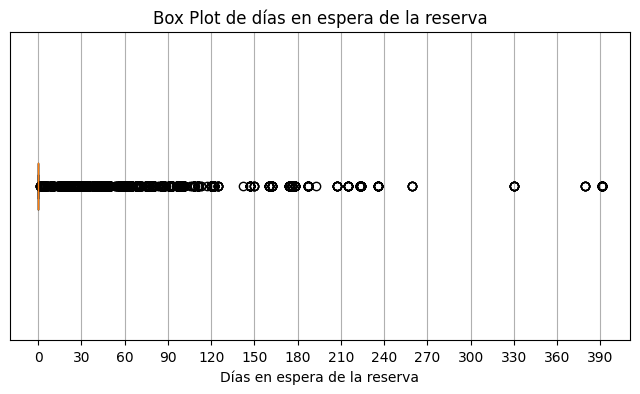

In [90]:
plt.figure(figsize=(8,4))
plt.boxplot(hotels_df['days_in_waiting_list'], vert=False)
plt.xlabel('Días en espera de la reserva')
plt.xticks(range(0, 400, 30))
plt.grid(axis='x')
plt.yticks([])
plt.title('Box Plot de días en espera de la reserva')
plt.show()

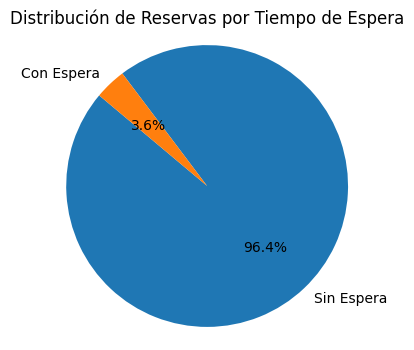

In [91]:
hotels_df_copy = hotels_df.copy()
waiting_list_counts = hotels_df_copy['days_in_waiting_list'].apply(lambda x: 'Sin Espera' if x == 0 else 'Con Espera')
waiting_list_counts = waiting_list_counts.value_counts()

plt.figure()
waiting_list_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Distribución de Reservas por Tiempo de Espera')
plt.ylabel('')
plt.axis('equal')
plt.show()

Como puede observarse, la mayoría de las reservas se hicieron sin espera. Ahora se propone volcar los porcentajes de cancelación dependiendo si hubo espera o no la hubo.

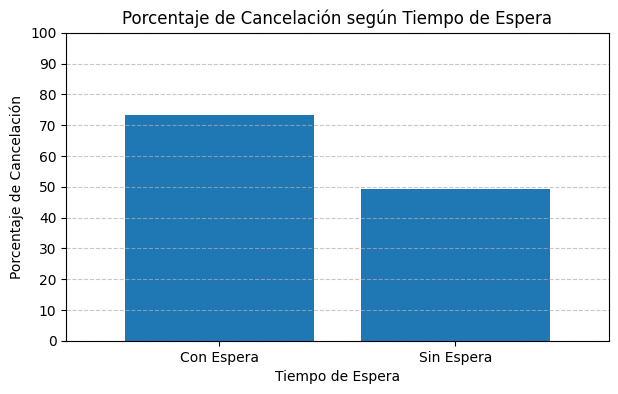

In [92]:
hotels_df_copy['days_in_waiting_list'].fillna(0, inplace=True)
hotels_df_copy['waiting_list_category'] = hotels_df_copy['days_in_waiting_list'].apply(lambda x: 'Sin Espera' if x == 0 else 'Con Espera')
cancellation_percentages = hotels_df_copy.groupby('waiting_list_category')['is_canceled'].mean() * 100

plt.figure(figsize=(7, 4))
cancellation_percentages.plot(kind='bar', width=0.8)
plt.title('Porcentaje de Cancelación según Tiempo de Espera')
plt.xlabel('Tiempo de Espera')
plt.ylabel('Porcentaje de Cancelación')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(range(0, 101, 10))
plt.ylim(0, 100)
plt.show()

Es claro que a mayor tiempo de espera de reserva, el porcentaje de cancelación aumenta. A continuación se presenta otro gráfico mostrando con los diversos días de espera por intervalo de 30 días:

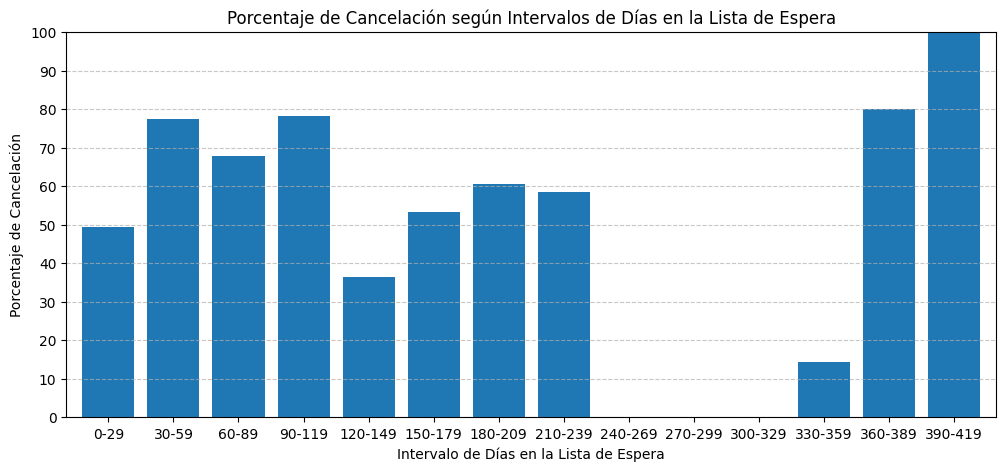

In [93]:
hotels_df_copy = hotels_df.copy()
hotels_df_copy['days_in_waiting_list'].fillna(0, inplace=True)
max_days_waiting = hotels_df_copy['days_in_waiting_list'].max()
interval_size = 30
num_intervals = int(max_days_waiting / interval_size) + 1
intervalos = [(i * interval_size, (i + 1) * interval_size) for i in range(num_intervals)]
etiquetas = [f'{start}-{end-1}' for start, end in intervalos]
hotels_df_copy['waiting_list_interval'] = pd.cut(hotels_df_copy['days_in_waiting_list'], bins=[start-1 for start, end in intervalos] + [float('inf')], labels=etiquetas)
cancellation_percentages = hotels_df_copy.groupby('waiting_list_interval', observed=False)['is_canceled'].mean() * 100

plt.figure(figsize=(12, 5))
cancellation_percentages.plot(kind='bar', width=0.8)
plt.title('Porcentaje de Cancelación según Intervalos de Días en la Lista de Espera')
plt.xlabel('Intervalo de Días en la Lista de Espera')
plt.ylabel('Porcentaje de Cancelación')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(range(0, 101, 10))
plt.ylim(0, 100)
plt.show()

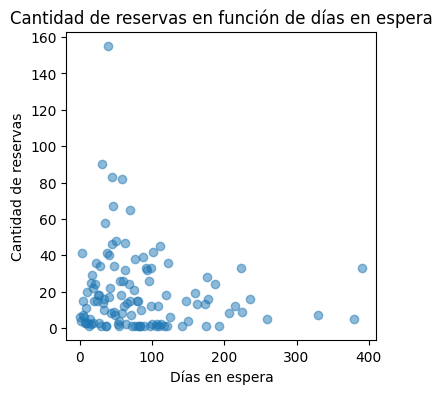

In [94]:
days_waiting_df = hotels_df['days_in_waiting_list'].value_counts()
days_waiting_df = days_waiting_df.drop(0)

plt.figure()
plt.scatter(days_waiting_df.index, days_waiting_df.values, alpha=0.5)
plt.title('Cantidad de reservas en función de días en espera')
plt.xlabel('Días en espera')
plt.ylabel('Cantidad de reservas')
plt.show()

Se puede ver que si hay espera, el porcentaje de cancelación es más alto. No se evidencia que haya una  relación lineal entre el tiempo de espera y su posible cancelación. Por lo que es **relevante** para el entrenamiento del modelo y está relacionada con el **target**. Los filas que según el boxplot eran outliers no son un problema dado a que esta variable será repensada como "está en lista de espera o no", por lo que los outliers caerían en la categoría "está en lista de espera".

#### customer_type

Este parámetro es una **Variable Independiente Cualitativa Texto Nominal** que indica el tipo de booking.

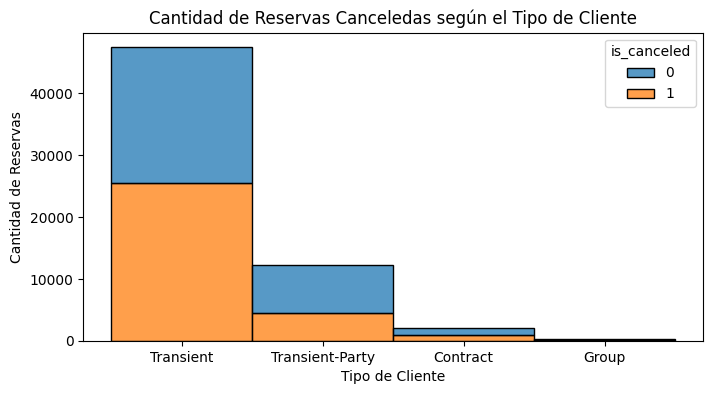

In [95]:
columns = ['customer_type', 'is_canceled']
data = hotels_df[columns]

plt.figure(figsize=(8, 4))
sns.histplot(data=data, x='customer_type', hue='is_canceled', multiple='stack', bins=4, legend=True)
plt.xlabel('Tipo de Cliente')
plt.ylabel('Cantidad de Reservas')
plt.title('Cantidad de Reservas Canceledas según el Tipo de Cliente')
plt.show()

Como se puede observar, la gran mayoría son Transient y en un porcentaje mucho menor Group. Se propone ahora analizar su relación con la variable target, analizando la probabilidad de cancelación dependiendo el grupo.

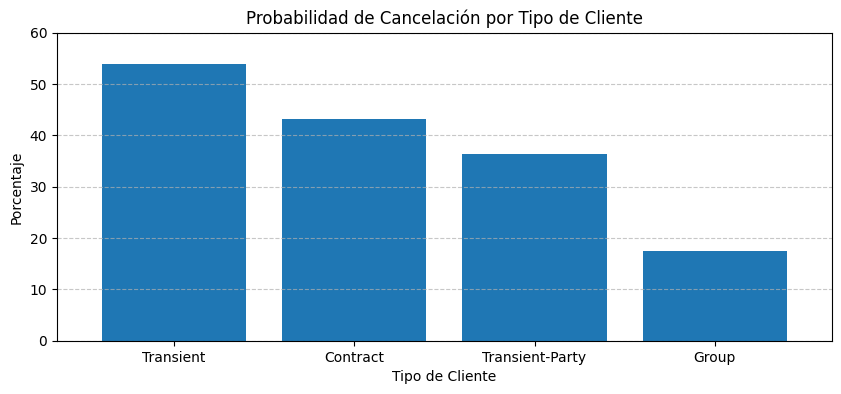

In [96]:
hotels_df_copy = hotels_df.copy()
cancellation_percentages = hotels_df_copy.groupby('customer_type')['is_canceled'].mean() * 100
cancellation_percentages = cancellation_percentages.sort_values(ascending=False)

plt.figure(figsize=(10, 4))
cancellation_percentages.plot(kind='bar', width=0.8)
plt.title('Probabilidad de Cancelación por Tipo de Cliente')
plt.xlabel('Tipo de Cliente')
plt.ylabel('Porcentaje')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(range(0, 61, 10))
plt.ylim(0, 60)
plt.show()

Es claro que hay una diferencia apreciable en el porcentaje de cancelaciones entre los distintos tipos, incluso entre Transient y Transient-Party que son los que más porcentaje poseen con respecto al total. Por lo que es un parámetro **relevante** para el entrenamiento del modelo y está relacionado con la variable **target**.

#### adr

Este parámetro es la Tarifa Promedio Diaria, que es una **Variable Independiente Cuantitativa Continua**.

In [97]:
parameter_column = hotels_df['adr'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a target): ", covarianza)
print("Correlación de Pearson (con respecto a target): ", pearson)

Media:  102.38377303635745
Mediana:  95.0
Varianza:  2280.755338320203
Desviación Estandar:  47.757254300474635
Moda:  62.0
Covarianza (con respecto a target):  1.1749917379839694
Correlación de Pearson (con respecto a target):  0.04920604939998624


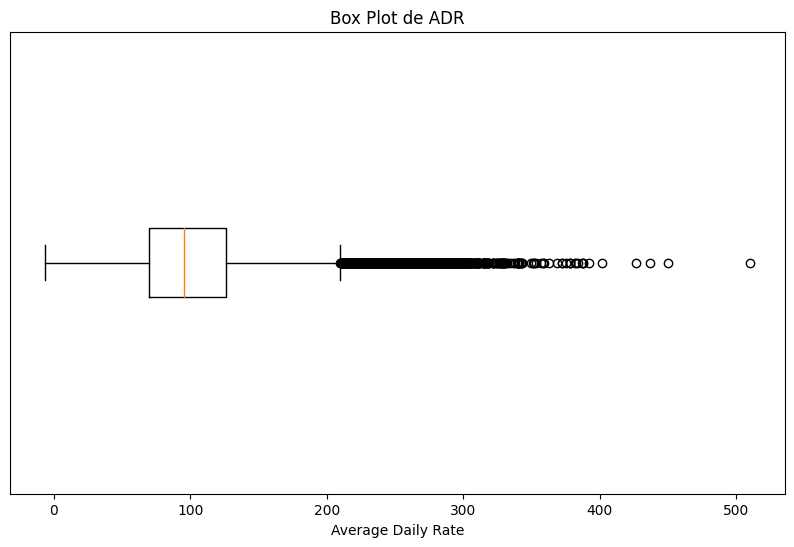

In [98]:
plt.figure(figsize=(10, 6))
plt.boxplot(hotels_df['adr'], vert=False)
plt.xlabel('Average Daily Rate')
plt.yticks([])
plt.title('Box Plot de ADR')
plt.show()

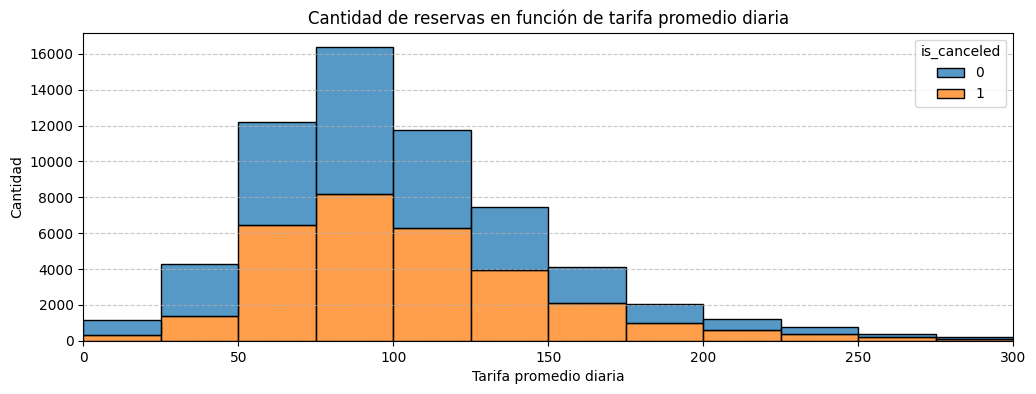

In [99]:
plt.figure(figsize=(12, 4))
sns.histplot(hotels_df[['adr', 'is_canceled']], x='adr', hue='is_canceled', multiple='stack', legend=True, bins = range(0,301,25))
plt.title('Cantidad de reservas en función de tarifa promedio diaria')
plt.xlabel("Tarifa promedio diaria")
plt.xlim(0, 300)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel("Cantidad")
plt.show()

Como se puede observar, la mayor cantidad de reservas se encuentran entre 75 y 100 de tarifa diaria de gasto. Se puede observar que toma la forma de una Campana de Gauss discretizada. Se propone ahora analizar el porcentaje de cancelación dependiendo el adr.

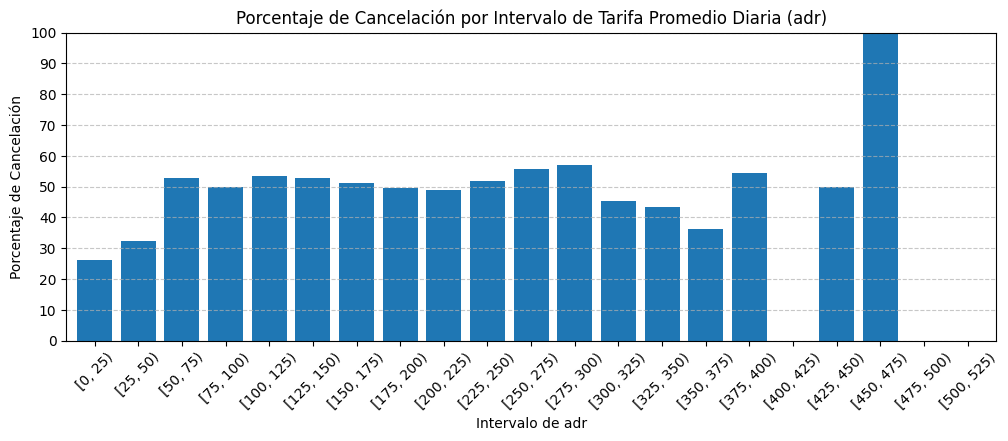

In [100]:
hotels_df_copy = hotels_df.copy()
adr_intervals = range(0, int(hotels_df_copy['adr'].max()) + 26, 25)
hotels_df_copy['adr_interval'] = pd.cut(hotels_df_copy['adr'], bins=adr_intervals, right=False)
cancellation_percentages = hotels_df_copy.groupby('adr_interval', observed=False)['is_canceled'].mean() * 100

plt.figure(figsize=(12, 4))
cancellation_percentages.plot(kind='bar', width=0.8)
plt.title('Porcentaje de Cancelación por Intervalo de Tarifa Promedio Diaria (adr)')
plt.xlabel('Intervalo de adr')
plt.ylabel('Porcentaje de Cancelación')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(range(0, 101, 10))
plt.show()

Analizando el box plot se ve que los valores mayores a 200 se pueden considerar outliers. Para los valores que hay mayor cantidad de muestras, entre 125 y 175 se observa que el porcentaje de cancelaciones es cercano al 50%, por lo cual se considera **irrelevante** para el entrenamiento del modelo y no guarda una relación considerable con la variable **target**.

#### required_car_parking_spaces

Este parámetro indica el número de autos requeridos para estacionamiento, es una **Variable Independiente Cuantitativa Discreta**.

In [101]:
parameter_column = hotels_df['required_car_parking_spaces'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a target): ", covarianza)
print("Correlación de Pearson (con respecto a target): ", pearson)

Media:  0.04995719800365028
Mediana:  0.0
Varianza:  0.048850522290548176
Desviación Estandar:  0.22102154259381182
Moda:  0
Covarianza (con respecto a target):  -0.02496649540365265
Correlación de Pearson (con respecto a target):  -0.22591549211844267


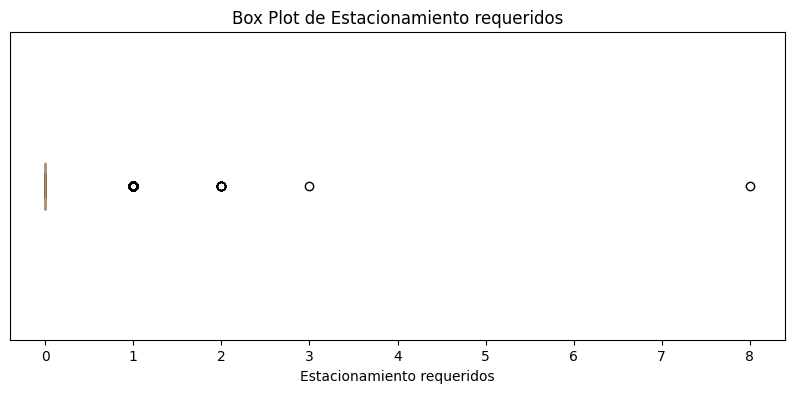

In [102]:
plt.figure(figsize=(10, 4))
plt.boxplot(hotels_df['required_car_parking_spaces'], vert=False)
plt.xlabel('Estacionamiento requeridos')
plt.yticks([])
plt.title('Box Plot de Estacionamiento requeridos')
plt.show()

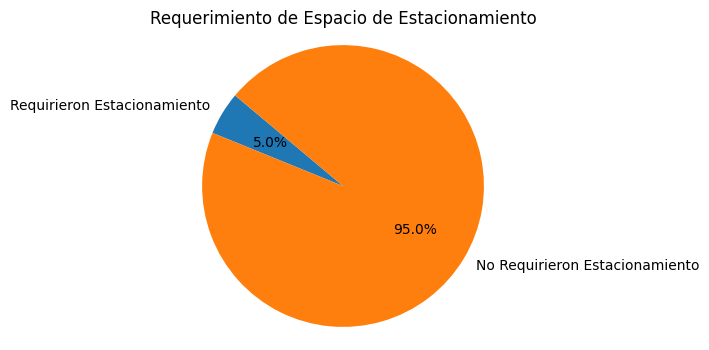

In [103]:
hotels_df_copy = hotels_df.copy()
parking_required = hotels_df_copy[hotels_df_copy['required_car_parking_spaces'] >= 1]
parking_not_required = hotels_df_copy[hotels_df_copy['required_car_parking_spaces'] == 0]

plt.figure(figsize=(4, 4))
plt.pie([len(parking_required), len(parking_not_required)], labels=['Requirieron Estacionamiento', 'No Requirieron Estacionamiento'], autopct='%1.1f%%', startangle=140)
plt.title('Requerimiento de Espacio de Estacionamiento')
plt.axis('equal')
plt.show()

Como se puede observar, la gran mayoría de clientes no requirieron de al menos un estacionamiento, pero un 5% sí lo hizo.

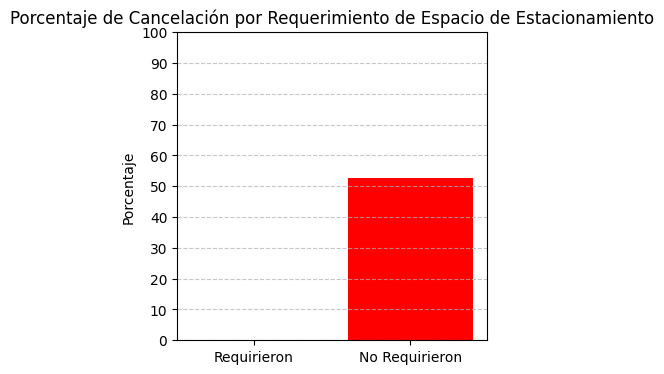

In [104]:
hotels_df_copy = hotels_df.copy()
parking_required = hotels_df_copy[hotels_df_copy['required_car_parking_spaces'] >= 1]
cancellation_percentage_required = parking_required['is_canceled'].mean() * 100
parking_not_required = hotels_df_copy[hotels_df_copy['required_car_parking_spaces'] == 0]
cancellation_percentage_not_required = parking_not_required['is_canceled'].mean() * 100

plt.figure()
plt.bar(['Requirieron', 'No Requirieron'], [cancellation_percentage_required, cancellation_percentage_not_required], color=['blue', 'red'])
plt.title('Porcentaje de Cancelación por Requerimiento de Espacio de Estacionamiento')
plt.ylabel('Porcentaje')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(range(0, 101, 10))
plt.ylim(0, 100)
plt.show()

El analisis de required_car_parking_spaces es muy peculiar. Se ven dos cosas muy claramente:

* La mayoria de los clientes no requieren estacionamiento.
* De los clientes que sí requieren estacionamiento, ninguno cancela sus reservas.

Teniendo en cuenta que no importó la cantidad de espacios requeridos, si no si fueron requeridos o no, sería conveniente analizar simplemente esto último.  
Dado este caso peculiar, no deberían tomarse como outliers los valores > 0 ya que brindan esta informacion útil. Por lo tanto el parámetro es **relevante** y está relacionado con el **target**.

#### total_of_special_requests

De forma similar al anterior, este parámetro indica el número de pedidos especiales hechos por el cliente. Es una **Variable Independiente Cuantitativa Discreta**.

In [105]:
parameter_column = hotels_df['total_of_special_requests'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a target): ", covarianza)
print("Correlación de Pearson (con respecto a target): ", pearson)

Media:  0.5237026149597015
Mediana:  0.0
Varianza:  0.6012544443420064
Desviación Estandar:  0.7754059867849915
Moda:  0
Covarianza (con respecto a target):  -0.09498776666022944
Correlación de Pearson (con respecto a target):  -0.24499744900638834


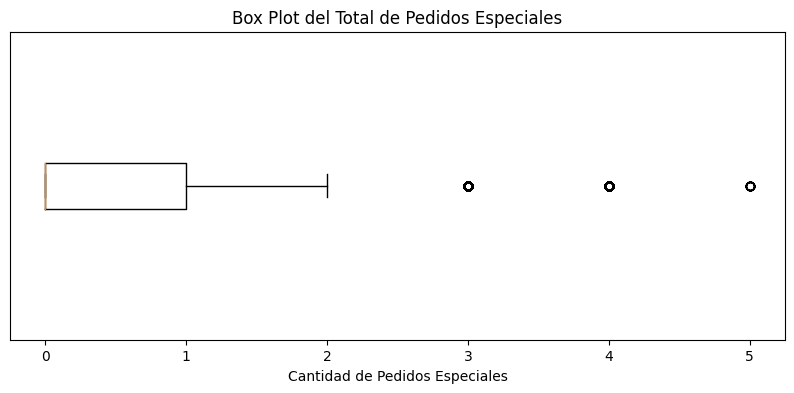

In [106]:
plt.figure(figsize=(10, 4))
plt.boxplot(hotels_df['total_of_special_requests'], vert=False)
plt.xlabel('Cantidad de Pedidos Especiales')
plt.yticks([])
plt.title('Box Plot del Total de Pedidos Especiales')
plt.show()

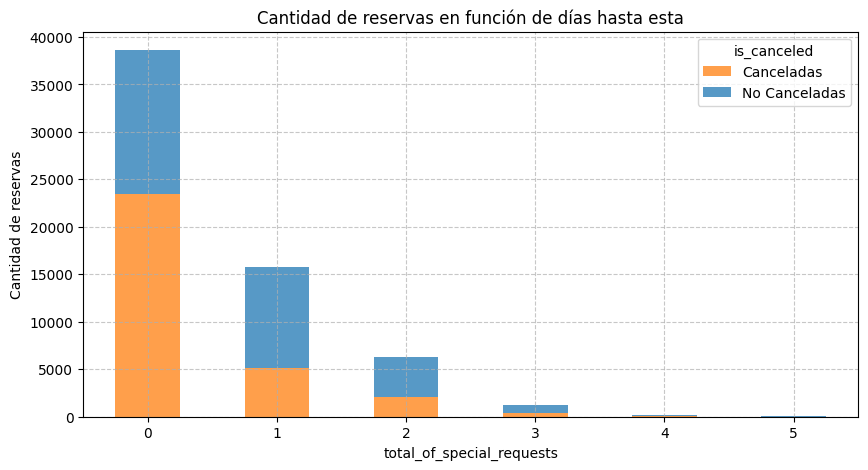

In [107]:
reservas = hotels_df.groupby(['total_of_special_requests', 'is_canceled']).size().unstack()
reservas = reservas[[1, 0]]

reservas.plot(kind='bar', stacked=True,  color=['#FF9F4B', '#5799C6'], figsize=(10, 5))
plt.xlim(-0.5, 5.5)
plt.title('Cantidad de reservas en función de días hasta esta')
plt.ylabel('Cantidad de reservas')
plt.xticks(rotation=0)
plt.legend(loc='upper right', title='is_canceled', labels=['Canceladas', 'No Canceladas'])
plt.grid(linestyle='--', alpha=0.7)
plt.show()

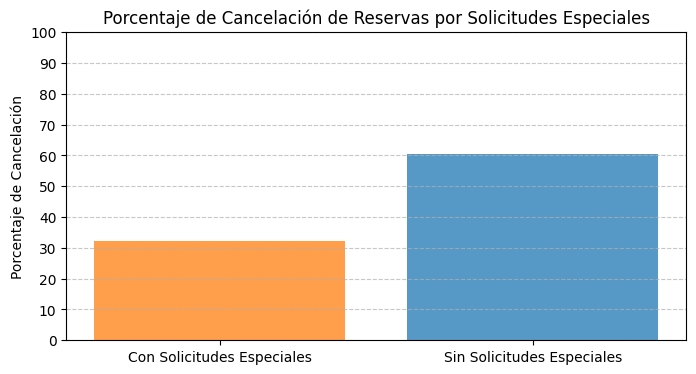

In [108]:
hotels_df_copy = hotels_df.copy()
with_special_requests = hotels_df_copy[hotels_df_copy['total_of_special_requests'] > 0]
without_special_requests = hotels_df_copy[hotels_df_copy['total_of_special_requests'] == 0]
cancellation_percentage_with = (with_special_requests['is_canceled'].mean()) * 100
cancellation_percentage_without = (without_special_requests['is_canceled'].mean()) * 100

plt.figure(figsize=(8, 4))
plt.bar(['Con Solicitudes Especiales', 'Sin Solicitudes Especiales'], [cancellation_percentage_with, cancellation_percentage_without], color=['#FF9F4B', '#5799C6'])
plt.title('Porcentaje de Cancelación de Reservas por Solicitudes Especiales')
plt.ylabel('Porcentaje de Cancelación')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(range(0, 101, 10))
plt.ylim(0, 100)
plt.show()

Es mucho mayor el porcentaje de reservas canceladas que no tenían solicitudes especiales, resta analizar los casos más específicos:

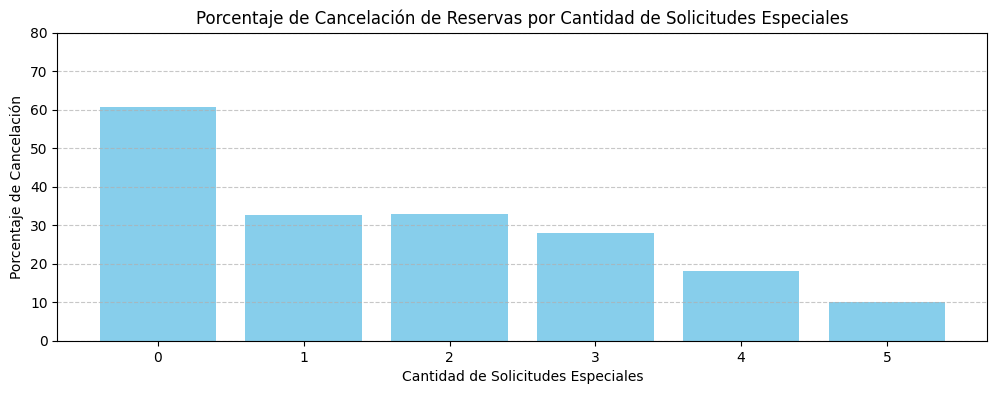

In [109]:
hotels_df_copy = hotels_df.copy()
unique_special_requests = hotels_df_copy['total_of_special_requests'].unique()
cancellation_percentages = []

for request_count in unique_special_requests:
    subset = hotels_df_copy[hotels_df_copy['total_of_special_requests'] == request_count]
    cancellation_percentage = (subset['is_canceled'].mean()) * 100
    cancellation_percentages.append(cancellation_percentage)

plt.figure(figsize=(12, 4))
plt.bar(unique_special_requests, cancellation_percentages, color='skyblue')
plt.title('Porcentaje de Cancelación de Reservas por Cantidad de Solicitudes Especiales')
plt.xlabel('Cantidad de Solicitudes Especiales')
plt.ylabel('Porcentaje de Cancelación')
plt.xticks(unique_special_requests)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(range(0, 81, 10))
plt.ylim(0, 80)
plt.show()

Como puede observarse el porcentaje de cancelación disminuye para mayor cantidad de solicitudes especiales, aunque vale la pena aclarar que no hay una cantidad relevante de muestras para valores con más de tres solicitudes especiales.  

Es un parámetro **relevante** y que guarda relación con el **target**.

#### id

Este parámetro simplemente indica el id de la reserva, no tiene sentido analizarlo. Es una **Variable Independiente Cualitativa Texto Nominal** ya que es una etiqueta sin relación alguna más que para identificar la reserva.

Vale aclarar que es **irrelevante** para el entrenamiento del modelo y no guarda relación con el **target**.

#### is_canceled

Este parámetro es un binario que simplemente muestra si una reserva fue cancelada o no. Es una **Variable Cualitativa Numérica Nominal**.

In [110]:
parameter_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)

Media:  0.499749648700596
Mediana:  0.0
Varianza:  0.24999993732422687
Desviación Estandar:  0.49999993732422293
Moda:  0


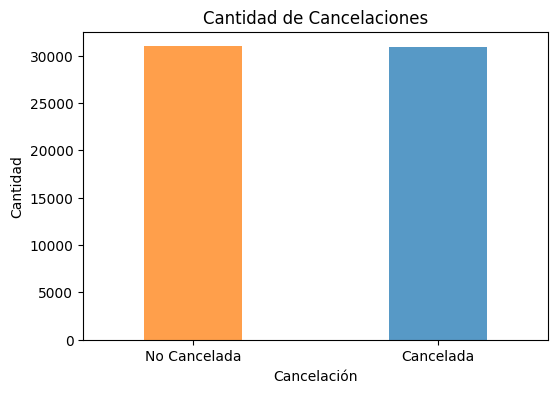

In [111]:
cancel_counts = hotels_df['is_canceled'].value_counts()

plt.figure(figsize=(6, 4))
cancel_counts.plot(kind='bar', width=0.4, color=['#FF9F4B', '#5799C6'])
plt.title('Cantidad de Cancelaciones')
plt.xlabel('Cancelación')
plt.ylabel('Cantidad')
plt.xticks([0, 1], ['No Cancelada', 'Cancelada'], rotation=0)
plt.show()

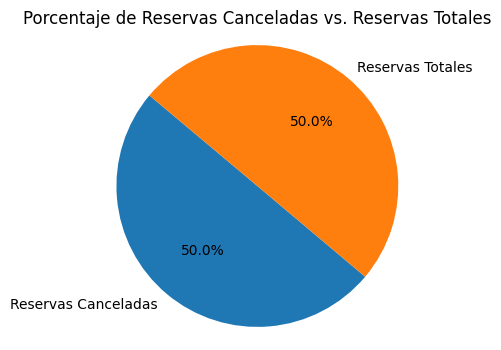

In [112]:
hotels_df_copy = hotels_df.copy()
total_reservations = len(hotels_df_copy[hotels_df_copy['is_canceled'] == 0])
cancelled_reservations = len(hotels_df_copy[hotels_df_copy['is_canceled'] == 1])
percentage_total = (total_reservations / total_reservations) * 100
percentage_cancelled = (cancelled_reservations / total_reservations) * 100

plt.figure(figsize=(4, 4))
plt.pie([percentage_cancelled, percentage_total], labels=['Reservas Canceladas', 'Reservas Totales'], autopct='%1.1f%%', startangle=140)
plt.title('Porcentaje de Reservas Canceladas vs. Reservas Totales')
plt.axis('equal')
plt.show()

Se tiene un dataset homogéneo en cuanto a la variable a predecir, siendo que prácticamente son la misma cantidad de casos cancelados que no cancelados.

### Parámetros **relevantes** y los **irrelevantes** en esta primera exploración inicial:  
  
**Relevantes:**  
* hotel  
* lead_time  
* arrival_date_month
* arrival_date_week_number  
* adults  
* babies 
* meal  
* country  
* market_segment  
* distribution_channel  
* is_repeated_guest  
* previous_cancellations  
* previous_bookings_not_canceled  
* reserved_room_type  
* assigned_room_type  
* booking_changes  
* deposit_type  
* agent  
* customer_type  
* days_in_waiting_list  
* required_car_parking_spaces  
* total_of_special_requests  
  
**Irrelevantes:**  
* arrival_date_year  
* arrival_date_day_of_month  
* stays_in_weeknd_nights  
* stays_in_week_days  
* children   
* company  
* adr  
* id

## Correlación de Pearson para todas las variables

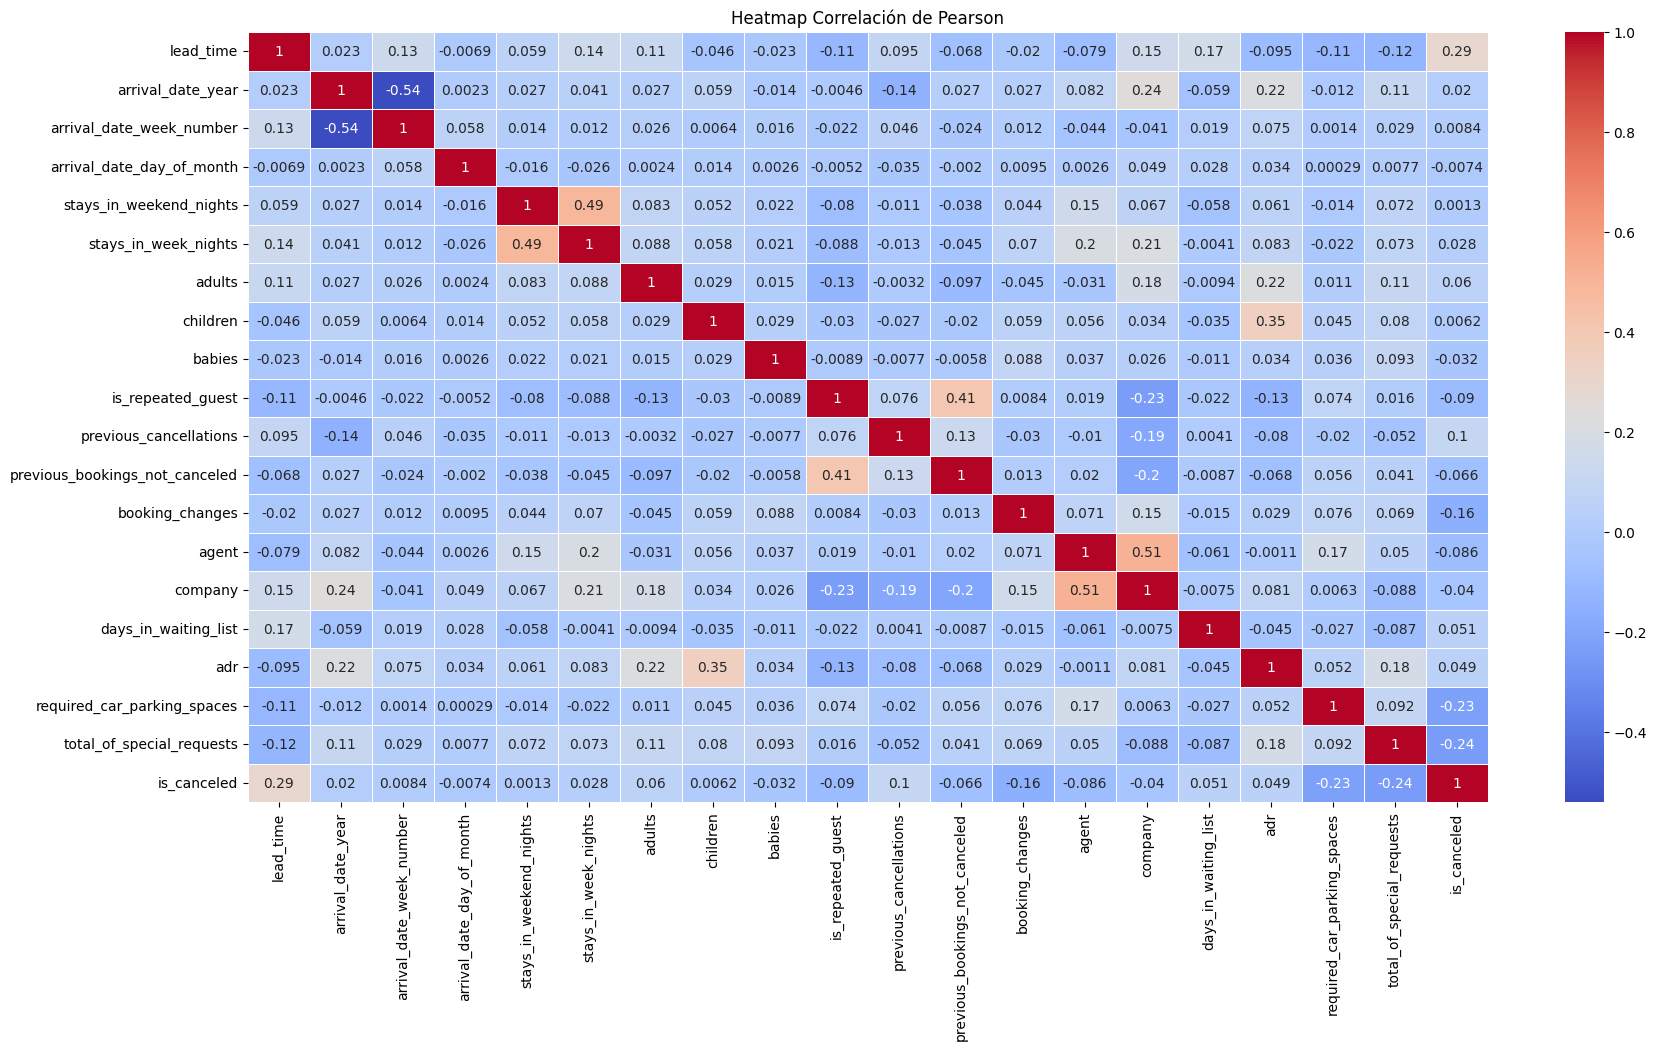

In [113]:
correlation_matrix = hotels_df.select_dtypes(include=['number']).corr()

plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap Correlación de Pearson')
plt.show()

Analizando el heatmap del Correlación de Pearson, se puede ver que no existen demasiadas correlaciones fuertes entre las variables. Hay solamente 2 correlaciones que pasan el ±0.5. Además, algunas variables con mayor correlación de Pearson no nos brindan información útil. Por ejemplo, hay una correlación entre stays_in_week_nights y stays_in_weekend_nights, que solamente nos indica qué reservas con más días de semana tiende a tener más días de fin de semana.